In [1]:
import pandas as pd
import warnings
import h5py 
import glob
import os
import numpy as np
import ast

### graphic libraries
import matplotlib.pyplot as plt
import seaborn as sns

import chromoscores.maputils as chrmap
import chromoscores.scorefunctions as chrsco
import chromoscores.snipping as chrsn
import cooler
from scipy.ndimage import gaussian_filter1d
from polychrom.polymer_analyses import slope_contact_scaling
from scipy import ndimage
from scipy.signal import argrelextrema
from scipy.signal import find_peaks
from scipy.optimize import fsolve

### making dictionary of simulations

In [2]:
path_dict = {}

directory = '/home1/rahmanin/start/polychrom/projects/Dynamic_boundary_elements/analysis/maps/maps_points_cools_eq/'

for name  in glob.glob(directory+'folder_*'):
    path_dict[name.split('_eq/')[1][:].split('.mcool')[0]]= name
path_dict = dict(sorted(path_dict.items()))
print(len(path_dict))

499


### Calculating average of peak score

In [3]:
file = open('../../../data/peak_score_averaged_hsteps_coolres10_points_eq.csv','w')

file.write('life,velocity,clife,cof,peak_ave\n')


for name in list(path_dict.keys()):
    params=[ast.literal_eval(i) for i in name.split('folder_')[1].split('_')[1::2]]
    face, back, clife, cof, life, slife, birth, pause, sep, site, mon, rep, step, vel = params
    f =pd.read_csv('../../../data/peakscore/peakscore_%s_hsteps_cool_res10_points_eq.csv' % name)
    f = f[f['chr_distance']<=7500]
    chr_dist = f['chr_distance']
    peak_score = f['peak_score']
    peak_ave = np.mean(peak_score[1:])
    file.write('%s,%s,%s,%s,%s\n'%(life, vel, clife,cof, peak_ave))
    
file.close()


### binding time vs unbinding time

In [4]:
file = pd.read_csv('../../../data/peak_score_averaged_hsteps_coolres10.csv')
file

,life,velocity,clife,cof,peak_ave
0,1500.0,3,1.5,0.15,1.033142
1,1500.0,1,1.5,0.15,1.028833
2,500.0,3,1.5,0.15,1.038300
3,500.0,1,1.5,0.15,1.018914
4,1500.0,3,1.5,0.30,1.014114
...,...,...,...,...,...
319,500.0,1,5000.0,50.00,1.342796
320,1500.0,3,5000.0,500.00,2.480192
321,1500.0,1,5000.0,500.00,1.607363
322,500.0,3,5000.0,500.00,2.217980


In [5]:
lifetime = file['life']
velocity = file['velocity']
clife = file['clife']
cof = file['cof']
file['occupancy']=(file['clife']/(file['clife']+file['cof'])).round(2)
occupancy = file['occupancy']
unique_life = np.unique(lifetime)
unique_vel = np.unique(velocity)
unique_clife = np.unique(clife)
unique_cof = np.unique(cof)
unique_occupancy = np.unique(file['occupancy'])
convertor = 21.875*60/500 # for converting time scale from lattice to second, based on reference cohesin lifetime of 21.875 min
#file['clife']=file['clife']*convertor #if need to convert
#file['cof']=file['cof']*convertor #if need to convert
file

,life,velocity,clife,cof,peak_ave,occupancy
0,1500.0,3,1.5,0.15,1.033142,0.91
1,1500.0,1,1.5,0.15,1.028833,0.91
2,500.0,3,1.5,0.15,1.038300,0.91
3,500.0,1,1.5,0.15,1.018914,0.91
4,1500.0,3,1.5,0.30,1.014114,0.83
...,...,...,...,...,...,...
319,500.0,1,5000.0,50.00,1.342796,0.99
320,1500.0,3,5000.0,500.00,2.480192,0.91
321,1500.0,1,5000.0,500.00,1.607363,0.91
322,500.0,3,5000.0,500.00,2.217980,0.91


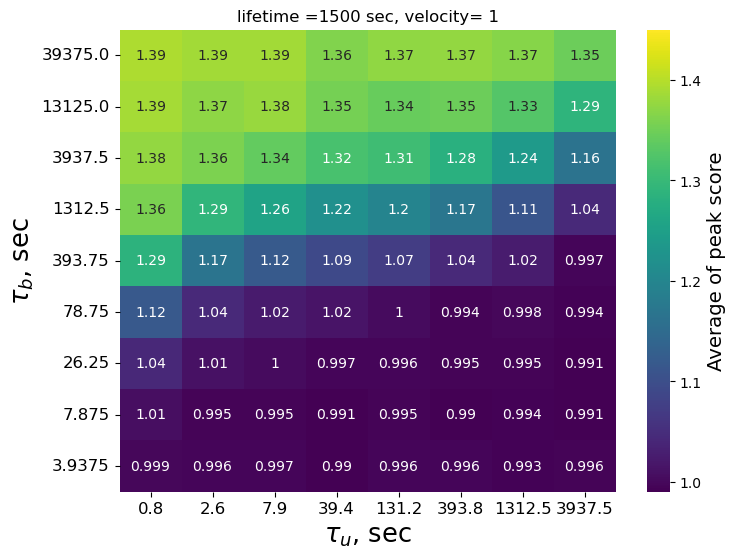

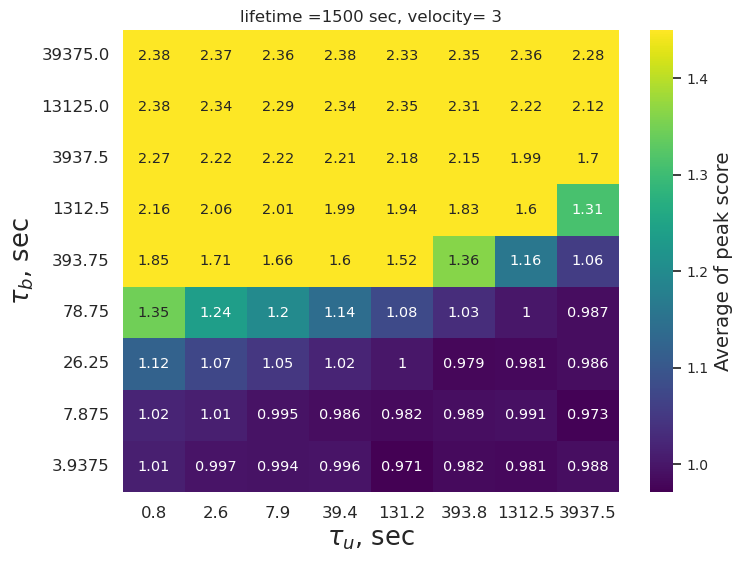

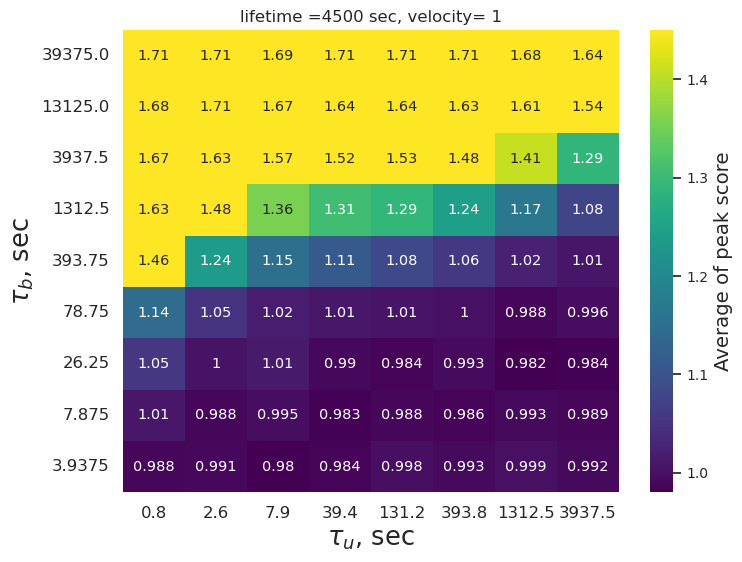

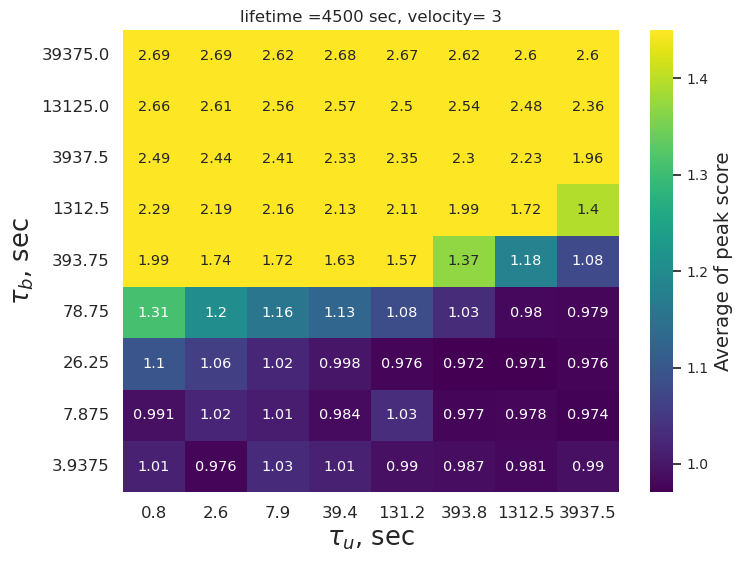

In [6]:
unique_life, unique_vel = [500, 1500],[1, 3]

for life in list(unique_life):
    for vel in list(unique_vel):
        new_file = file[(lifetime == life)&(velocity == vel) ][['clife','cof','peak_ave']]
        new_file = new_file[new_file['cof']>0.15]
        new_file['clife']= convertor* new_file['clife']
        new_file['cof']= convertor*new_file['cof']
        heatmap_data = new_file.pivot('clife', 'cof', 'peak_ave')


        smooth_scale = 1
        z = ndimage.zoom(heatmap_data.to_numpy(), smooth_scale)
        
        # Create the heatmap using seaborn
        plt.figure(figsize=(8, 6))
        im = sns.heatmap(heatmap_data, annot=True, cmap='viridis', vmax = 1.45,fmt='.3g',cbar_kws={'label': 'Average of peak score'} )
        sns.set(font_scale=0.871)
        # Customize labels and title
        cbar = im.collections[0].colorbar
        cbar.ax.tick_params(labelsize=10)
        cbar.set_label('Average of peak score', fontsize=14.15) 

        im.set_xticklabels(['{:.1f}'.format(float(t.get_text())) for t in im.get_xticklabels()])
        plt.xlabel(r'$\tau_u$, sec', fontsize = 18.5)
        plt.ylabel(r'$\tau_b$, sec', fontsize =18.5)
        plt.title('lifetime =%s sec, velocity= %s'%(life*3, vel),fontsize = 11.95)
        plt.xticks(fontsize=11.95)
        plt.yticks(fontsize=11.95)
        plt.gca().invert_yaxis()
        #plt.savefig('../../../images/sweep_peak_ave_for_%s_%s_coolres10.pdf'%(life, vel), transparent = True, bbox_inches = 'tight')
        # Show the plot
        plt.show()



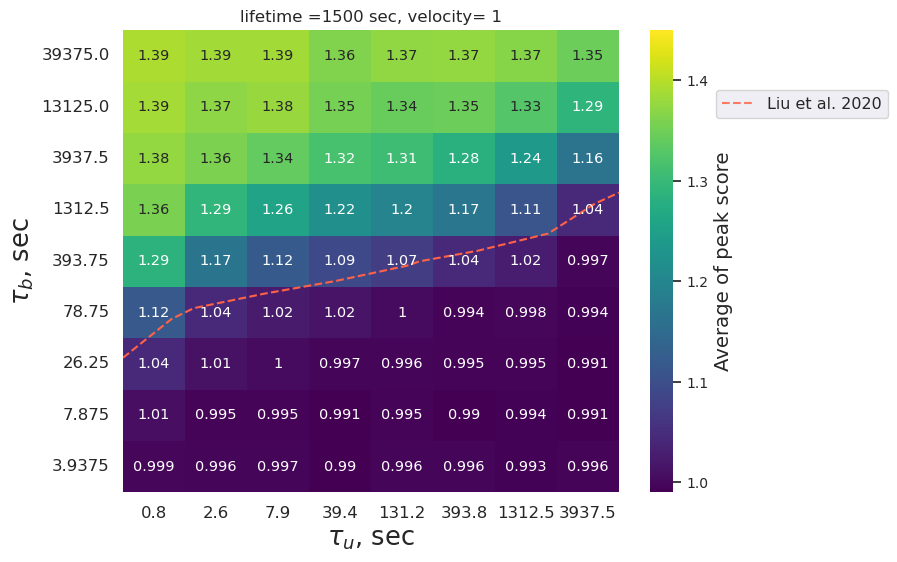

In [7]:
unique_life, unique_vel = [500],[1]

for life in list(unique_life):
    for vel in list(unique_vel):
        new_file = file[(lifetime == life)&(velocity == vel) ][['clife','cof','peak_ave']]
        new_file = new_file[new_file['cof']>0.15]
        new_file['clife']= convertor* new_file['clife']
        new_file['cof']= convertor*new_file['cof']
        heatmap_data = new_file.pivot('clife', 'cof', 'peak_ave')


        smooth_scale = 1
        z = ndimage.zoom(heatmap_data.to_numpy(), smooth_scale)
        
        # Create the heatmap using seaborn
        plt.figure(figsize=(8, 6))
        im = sns.heatmap(heatmap_data, annot=True, cmap='viridis', vmax = 1.45,fmt='.3g',cbar_kws={'label': 'Average of peak score'} )
        sns.set(font_scale=0.871)
        # Customize labels and title
        cbar = im.collections[0].colorbar
        cbar.ax.tick_params(labelsize=10)
        cbar.set_label('Average of peak score', fontsize=14.15) 



        # Add equipotential lines for loop size = 700
        cntr1 = im.contour(np.linspace(0, 8, 8*smooth_scale),
                           np.linspace(0, 9, 9*smooth_scale),
                           heatmap_data.to_numpy(), levels=[1.066], colors='tomato', linestyles='dashed', alpha=1) 


        Liu_line, = plt.plot([], [], color='tomato', linestyle='dashed', alpha=0.83, label='Liu et al. 2020')
        x_cntr1 = np.linspace(0, 8, 8*smooth_scale)
        y_cntr1 = np.interp(x_cntr1, cntr1.collections[0].get_paths()[0].vertices[:,0], 
                            cntr1.collections[0].get_paths()[0].vertices[:,1])
        
        
        
        im.set_xticklabels(['{:.1f}'.format(float(t.get_text())) for t in im.get_xticklabels()])
        plt.xlabel(r'$\tau_u$, sec', fontsize = 18.5)
        plt.ylabel(r'$\tau_b$, sec', fontsize =18.5)
        plt.title('lifetime =%s sec, velocity= %s'%(life*3, vel),fontsize = 11.95)
        plt.xticks(fontsize=11.95)
        plt.yticks(fontsize=11.95)
        plt.gca().invert_yaxis()
        plt.legend(handles=[Liu_line], loc=(1.195,0.81), fontsize =11.5)
        #plt.savefig('../figs/peak_ave_for_%s_%s_coolres10.pdf'%(life, vel), transparent = True, bbox_inches = 'tight')
        plt.show()



### Peaks score vs Frip for various binding time

In [19]:
frip = pd.read_csv('../../../data/fripscore_sep_100.csv')


frip = frip[(frip[' clife']<=5000)&(frip[' cof']>=0.3)]
lifetime = frip['lifetime']
velocity = frip[' velocity']
clife = frip[' clife']
cof = frip[' cof']
frip['occup']=(1*(frip[' clife'])/(frip[' clife']+frip[' cof']))

unique_life = np.unique(lifetime)
unique_vel = np.unique(velocity)
unique_clife = np.unique(clife)
unique_cof = np.unique(cof)
unique_occupancy = np.unique(frip['occup'])

frip=frip[frip[' clife']==10*frip[' cof']]

#frip

In [20]:
peak=pd.read_csv('../../../data/peak_score_averaged_hsteps_coolres10_points.csv')

peak = peak[(peak['clife']<=5000)&(peak['cof']>=0.3)]
lifetime = peak['life']
velocity = peak['velocity']
clifetime = peak['clife']
coftime = peak['cof']
peakscore = peak['peak_ave']
peak['occup']=(1*(peak['clife'])/(peak['clife']+peak['cof']))
unique_life = np.unique(lifetime)
unique_vel = np.unique(velocity)
unique_clife = np.unique(clifetime)
unique_cof = np.unique(coftime)
unique_occupancy = np.unique(peak['occup'])


peak=peak[peak['clife']==10*peak['cof']]

peak

,life,velocity,clife,cof,peak_ave,occup


In [55]:
lifes, vels = [500, 1500] , [1, 3]

file= open('../../data/peak_frip_tau_cool_res10.csv','w')
file.write('vel,life,clife,frip_ave,peak_aver\n')
mat = []
for life in lifes:
    for vel in vels:
        if (life==1500 and vel==3): continue
        for clife in unique_clife:
            #print(clife)
            new_frip = frip[(frip['lifetime'] == life)&(frip[' velocity'] == vel)&(frip[' clife']==clife)][['occup',' cof', ' fripscore']]
            new_peak = peak[(peak['life'] == life)&(peak['velocity'] == vel)&(peak['clife']==clife)][['occup','cof', 'peak_ave']]
            new_frip_filtered = new_frip.drop_duplicates(keep = 'first')
            new_peak_filtered = new_peak.drop_duplicates(keep = 'first')
            new_frip_filtered = new_frip_filtered.sort_values('occup')
            new_peak_filtered = new_peak_filtered.sort_values('occup')
            new_clife = new_peak_filtered['occup']
            frip_score = new_frip_filtered[' fripscore']
            peak_score = new_peak_filtered['peak_ave']
            if frip_score.empty or peak_score.empty:
                #print('y')
                continue
            mat.append([vel, life, clife, np.mean(frip_score), np.mean(peak_score)])
            file.write('%s,%s,%s,%s,%s\n'%(vel, life, clife, np.mean(frip_score), np.mean(peak_score)))

mat = np.array(mat)
file.close()

In [56]:
file = '../../data/peak_frip_tau_cool_res10.csv'  
data = pd.read_csv(file)
data

,vel,life,clife,frip_ave,peak_aver
0,1,500,3.0,0.034045,1.006439
1,1,500,10.0,0.037867,1.010509
2,1,500,30.0,0.060478,1.024080
3,1,500,150.0,0.156131,1.092350
4,1,500,500.0,0.269420,1.197872
5,1,500,1500.0,0.345887,1.282378
6,1,500,5000.0,0.389708,1.327125
7,3,500,3.0,0.033701,1.016827
8,3,500,10.0,0.056528,1.069178
9,3,500,30.0,0.119565,1.189600


/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "ppt" which is no longer supported as of 3.3 and will become an error in 3.6


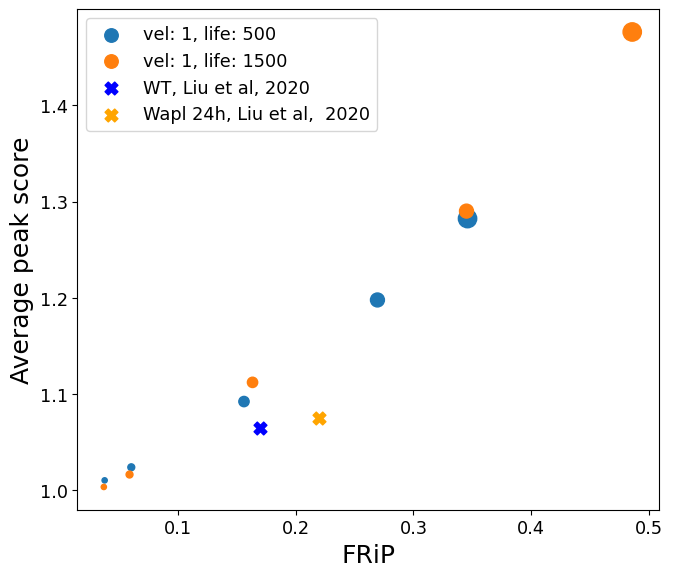

In [59]:
file = '../../data/peak_frip_tau_cool_res10.csv'  
data = pd.read_csv(file)
#data = data[(data['occupancy_rate']<0.999)&(data['occupancy_rate']>0.78)]
data=data[(data['clife']>5)&(data['clife']<5000)]
unique_vel = data['vel'].unique()
unique_life = data['life'].unique()

#colors = plt.cm.viridis(np.linspace(0, 1, len(unique_vel) * len(unique_life)))

plt.figure(figsize=(7.5, 6.5))
for i, vel in enumerate(unique_vel):
    for j, life in enumerate(unique_life):
        if vel==3.0 and life==1500.0: continue
        if vel==3.0: continue
        subset = data[(data['vel'] == vel) & (data['life'] == life)]
        plt.scatter(subset['frip_ave'],subset['peak_aver'],  
                    s=np.sqrt(subset['clife'])*4.5, label=f'vel: {vel}, life: {life}')
Liu_WT = [0.17, 1.065]
Liu_Wapl = [0.22, 1.075]
plt.scatter(np.array(Liu_WT)[0], np.array(Liu_WT)[1], label='WT, Liu et al, 2020',color='blue', marker='X',s=85)
plt.scatter(np.array(Liu_Wapl)[0], np.array(Liu_Wapl)[1],label='Wapl 24h, Liu et al,  2020',color='orange', marker = 'X',s=85)
plt.xlabel('FRiP',fontsize=18)
plt.ylabel('Average peak score', fontsize =18)
#plt.title('Frip vs peak')
#plt.legend(  bbox_to_anchor=(1,1))
#plt.ylim(0.9,1.35)
plt.xticks(fontsize=12.75)
plt.yticks(fontsize=12.75)
plt.legend(fontsize=12.75)
plt.savefig('../../images/peak_vs_frip.pdf',transparent=True, ppt=500)

#plt.grid(True)
plt.show()

### curves of dot score with distance

In [21]:
f=open('../../../data/peakscore/peakscore_%s_hsteps_cool_res10_points_eq.csv' % name,'w')

In [22]:
def smooth(x, sigma = 1.5):
        return gaussian_filter1d(x, sigma)

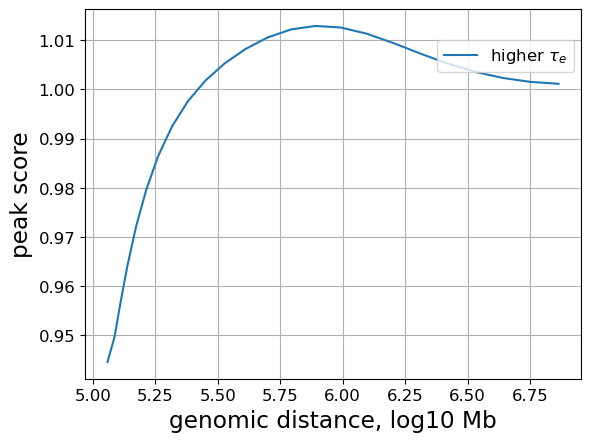

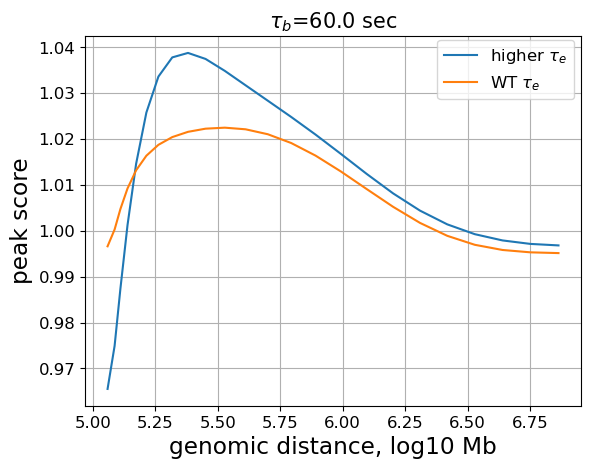

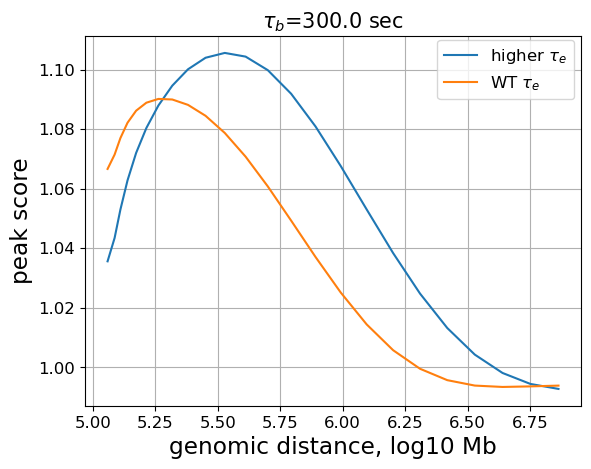

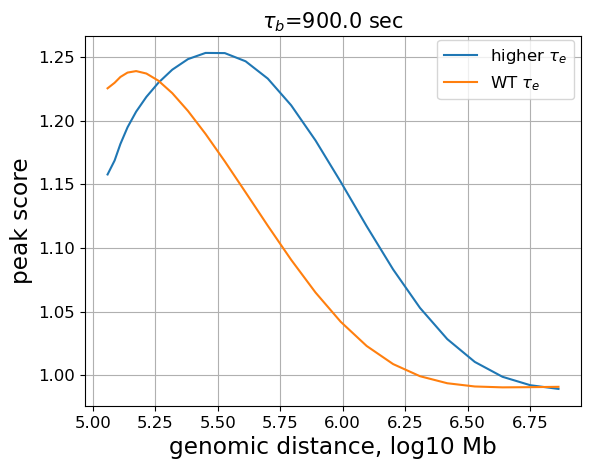

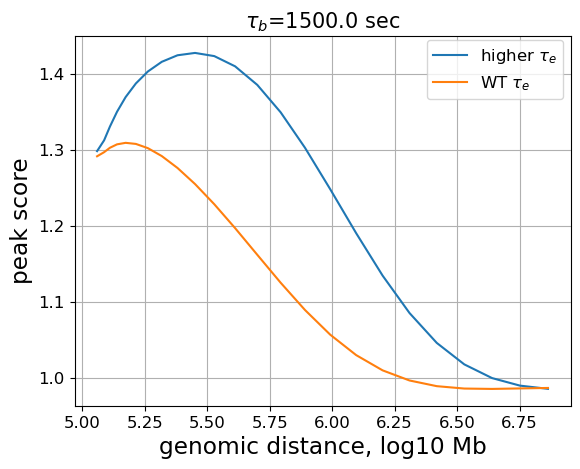

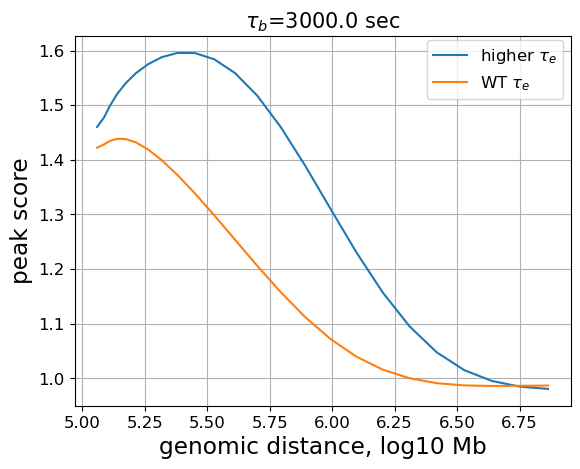

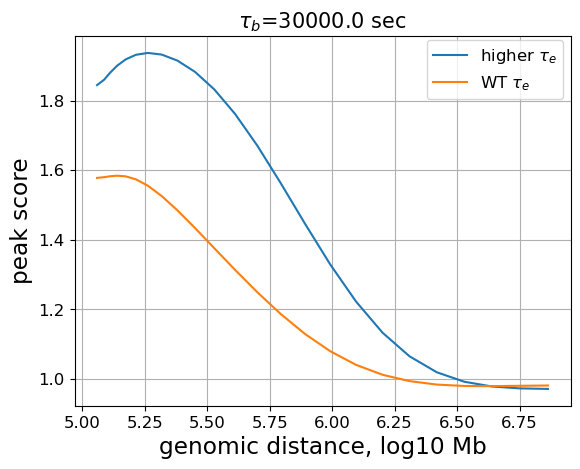

In [23]:
life_range, vel_range = 500, 1

clife_range = [ 11.43, 22.86,  114.29, 342.86, 571.43, 1142.86, 11428.57]
i = 1
convertor=21.875*60/500
for clife_val in clife_range:
    i+=1
    for name in list(path_dict.keys()):
        params=[ast.literal_eval(i) for i in name.split('folder_')[1].split('_')[1::2]]
        face, back, clife, cof, life, slife, birth, pause, sep, site, mon, rep, step, vel = params
        if step==400.0: continue
        if clife==clife_val:
            if life == 1500 and vel ==1 and np.round((clife/(clife+cof)),2)==0.7:
                f=pd.read_csv('../../../data/peakscore/peakscore_%s_hsteps_cool_res10_points.csv' % name)
                f = f.dropna()
                f=f[f['chr_distance']<=750000]
                #print(f)
                chr_dist = f['chr_distance']
                peak_score = f['peak_score']
                peaks = find_peaks(peak_score)
                #print(peaks)
                #plt.loglog(chr_dist, smooth(peak_score),label=r'$\tau$=%s, $\tau\prime$=%s, occup$\sim$0.9'%(clife,cof),color = colors[i])
                pixel_start = 1
                end_region=30
                plt.plot(np.log10(chr_dist[pixel_start:end_region]*1000), smooth(peak_score,3)[pixel_start:end_region],label = r'higher $\tau_e$')#,label=r'$\tau_b$=%s sec, $\tau_u$=%s sec'%(np.round(clife*convertor),np.round(cof*convertor)))
                #plt.title('lifetime = %s, velocity = %s'%(life,vel))
            if life == 500 and vel ==1 and np.round((clife/(clife+cof)),2)==0.7:
                f=pd.read_csv('../../../data/peakscore/peakscore_%s_hsteps_cool_res10_points.csv' % name)
                f=f.dropna()
                chr_dist = f['chr_distance']
                peak_score = f['peak_score']
                peaks = find_peaks(peak_score)
                #print(peaks)
                #plt.loglog(chr_dist, smooth(peak_score),label=r'$\tau$=%s, $\tau\prime$=%s, occup$\sim$0.9'%(clife,cof),color = colors[i])
                plt.plot(np.log10(chr_dist[pixel_start:end_region]*1000), smooth(peak_score,3)[pixel_start:end_region], label = r'WT $\tau_e$')#,label=r' $\tau_b$=%s sec, $\tau_u$=%s sec'%(np.round(clife*convertor),np.round(cof*convertor)))
                plt.title(r'$\tau_b$=%s sec'%(np.round(clife*convertor)), fontsize = 15)
    
    plt.grid(True)
    plt.ylabel('peak score',fontsize = 16.75)
    plt.xlabel('genomic distance, log10 Mb', fontsize = 16.75)
    plt.legend(loc=(0.71,0.83), fontsize = 11.95)
    plt.xticks(fontsize=11.95)
    plt.yticks(fontsize=11.95)
    #plt.legend()
    plt.savefig('../figs/peak_and_distance_clife_%s.pdf'%clife_val,bbox_inches = 'tight',transparent=True)
    plt.show()

### with orientation

convergent +-

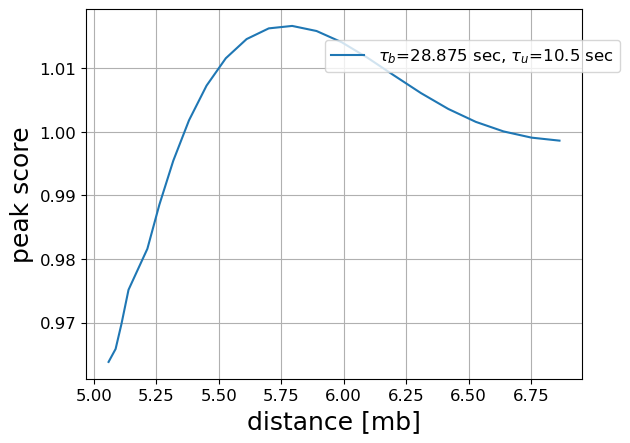

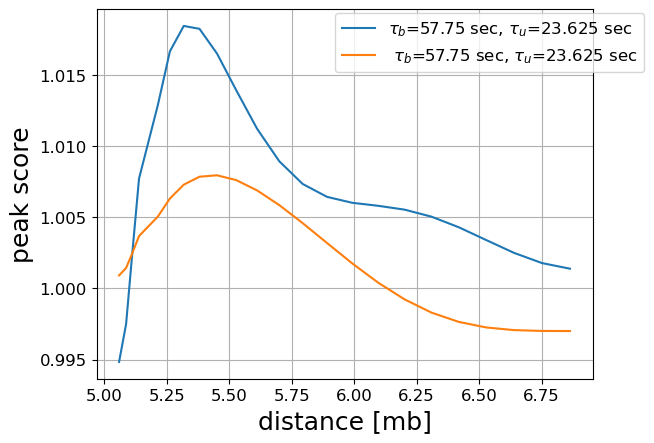

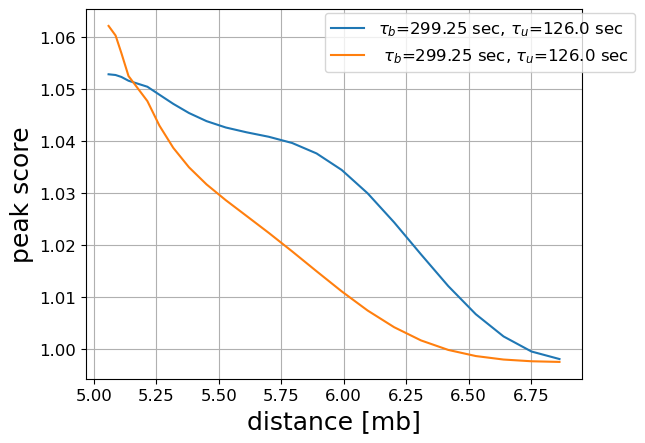

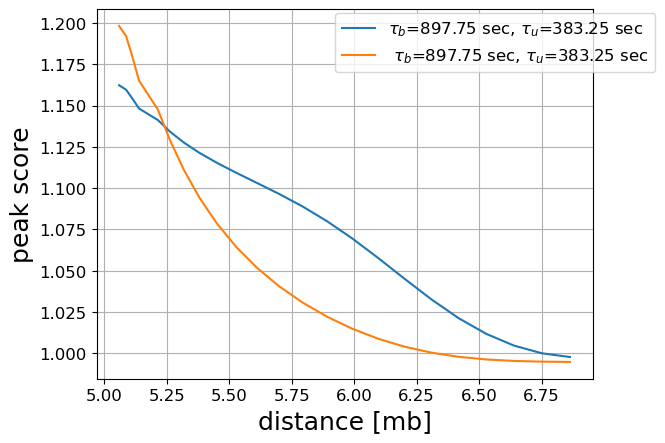

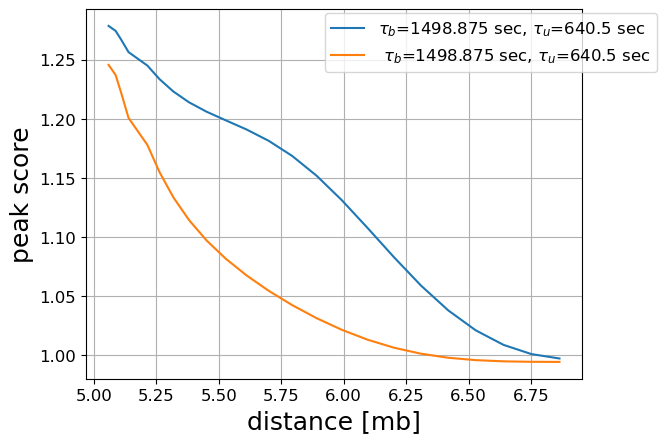

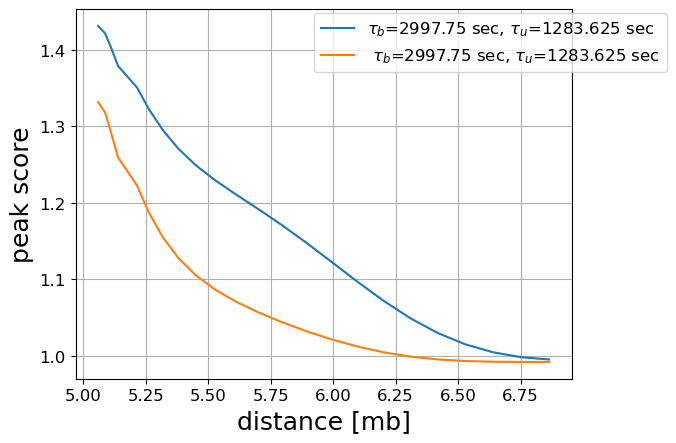

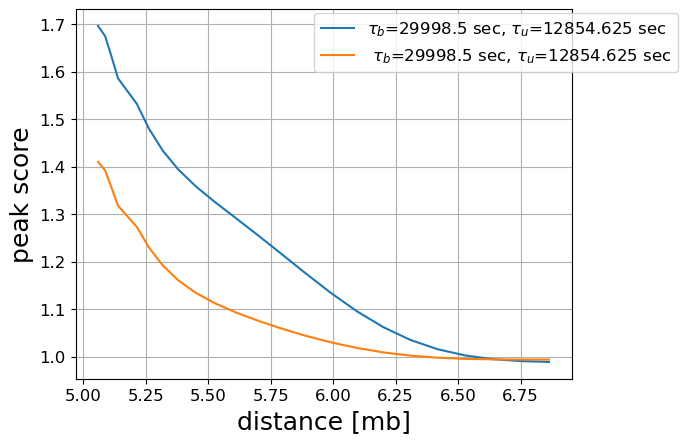

In [17]:
life_range, vel_range = 500, 1

clife_range = [ 11.43, 22.86,  114.29, 342.86, 571.43, 1142.86, 11428.57]
i = 1
def smooth(x, sigma = 3.95):
        return gaussian_filter1d(x, sigma)
convertor = 21.875*60/500
for clife_val in clife_range:
    i+=1
    for name in list(path_dict.keys()):
        #print(name)
        params=[ast.literal_eval(i) for i in name.split('folder_')[1].split('_')[1::2]]
        face, back, clife, cof, life, slife, birth, pause, sep, site, mon, rep, step, vel = params
        if clife==clife_val:
            if life == 1500 and vel ==1 and np.round((clife/(clife+cof)),2)==0.7:
                f=pd.read_csv('../../../data/peakscore_with_orientation/peakscore_%s_hsteps_orientation_cool_res_10_points_eq.csv' % name)
                f = f[f['orientation']=='+-']
                chr_dist = f['chr_distance']
                peak_score = f['peak_score']
                peaks = find_peaks(peak_score)
                plt.plot(np.log10(chr_dist[1:]*1000), smooth(peak_score[1:], 3.5),label=r'$\tau_b$=%s sec, $\tau_u$=%s sec'%(int(clife)*convertor,int(cof)*convertor))
                #plt.title('lifetime = %s, velocity = %s'%(life,vel))
            if life == 500 and vel ==1 and np.round((clife/(clife+cof)),2)==0.7:
                f=pd.read_csv('../../../data/peakscore_with_orientation/peakscore_%s_hsteps_orientation_cool_res_10_points_eq.csv' % name)
                f = f[f['orientation']=='+-']
                chr_dist = f['chr_distance']
                peak_score = f['peak_score']
                peaks = find_peaks(peak_score)
                plt.plot(np.log10(chr_dist[1:]*1000), smooth(peak_score[1:], 3.5),label=r' $\tau_b$=%s sec, $\tau_u$=%s sec'%( int(clife)*convertor,int(cof)*convertor))
                #plt.title('lifetime = %s, velocity = %s'%(life,vel))
    #plt.xlim(4.3, 6.71)
    plt.grid(True)
    plt.ylabel('peak score',fontsize = 18)
    plt.xlabel('distance [mb]', fontsize = 18)
    plt.legend(loc=(0.481,0.83), fontsize = 11.95)
    plt.xticks(fontsize=11.95)
    plt.yticks(fontsize=11.95)
    #plt.title('convergent')
    plt.savefig('../../../images/peak_and_distance_clife_%s_conv.pdf'%clife_val,bbox_inches = 'tight',transparent=True)
    plt.show()

divergent -+

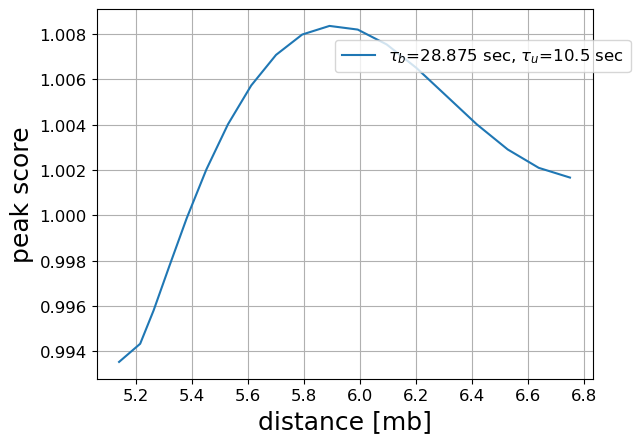

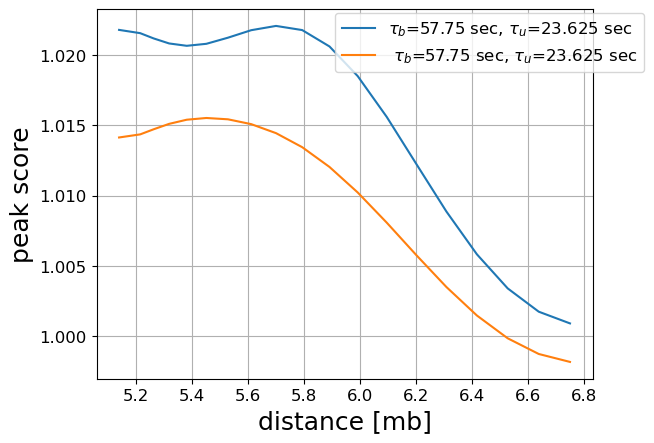

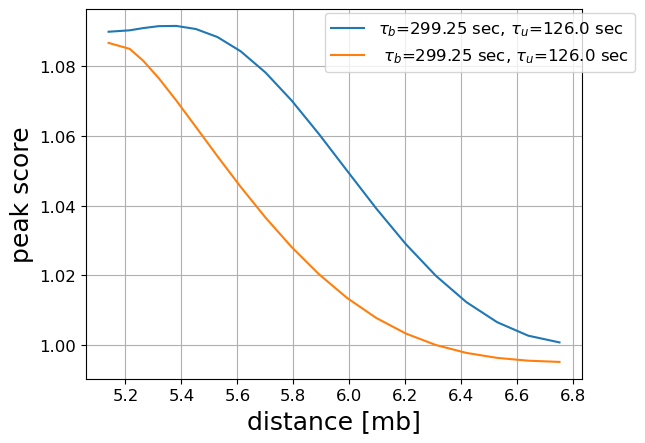

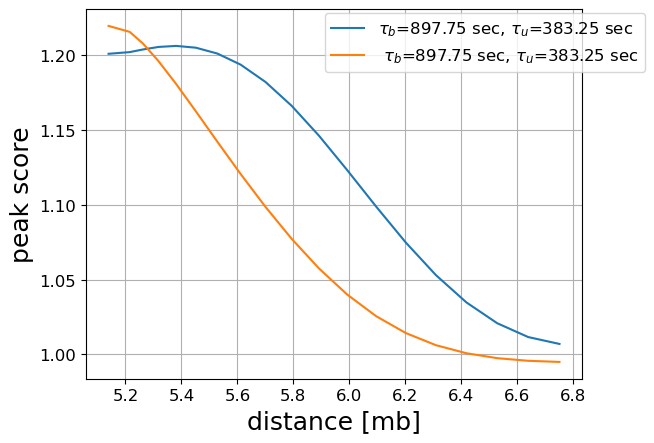

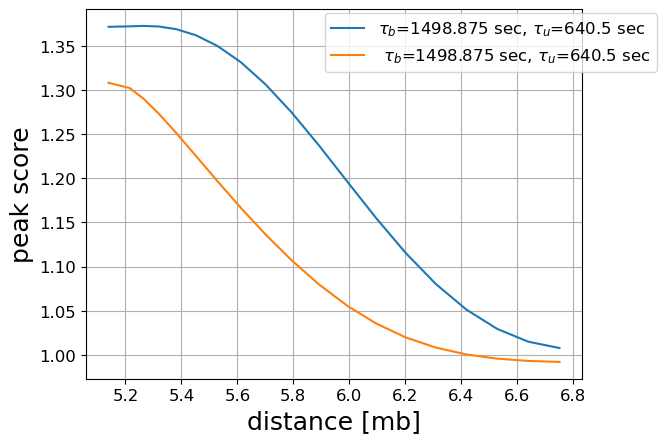

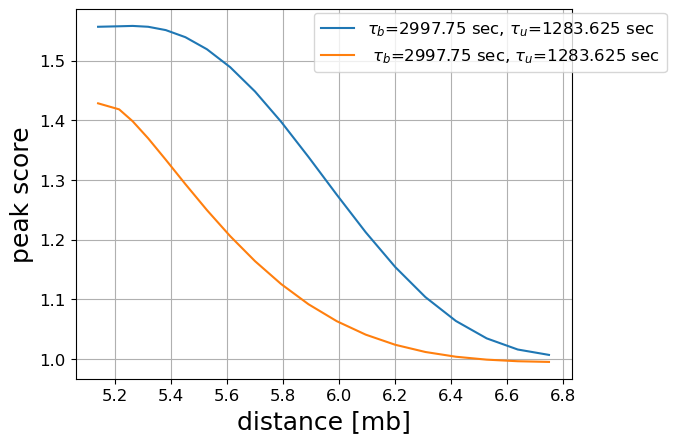

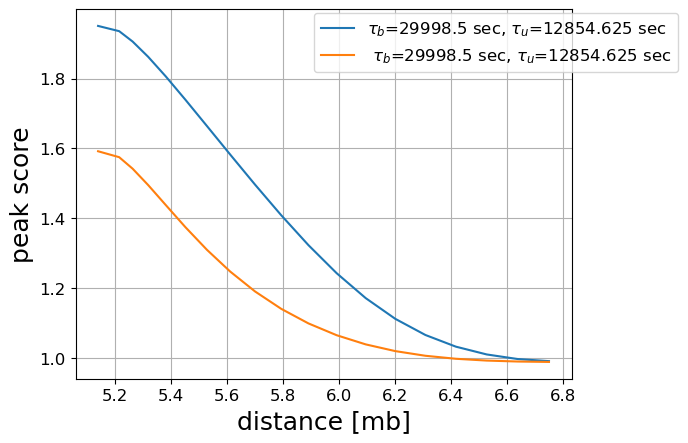

In [18]:
life_range, vel_range = 500, 1

clife_range = [ 11.43, 22.86,  114.29, 342.86, 571.43, 1142.86, 11428.57]
i = 1
convertor = 21.875*60/500
for clife_val in clife_range:
    for name in list(path_dict.keys()):
        params=[ast.literal_eval(i) for i in name.split('folder_')[1].split('_')[1::2]]
        face, back, clife, cof, life, slife, birth, pause, sep, site, mon, rep, step, vel = params
        if clife==clife_val:
            if life == 1500 and vel ==1 and np.round((clife/(clife+cof)),2)==0.7:
                f=pd.read_csv('../../../data/peakscore_with_orientation/peakscore_%s_hsteps_orientation_cool_res_10_points_eq.csv' % name)
                f = f[f['orientation']=='-+']
                chr_dist = f['chr_distance']
                peak_score = f['peak_score']
                peaks = find_peaks(peak_score)
                #print(peaks)
                #plt.loglog(chr_dist, smooth(peak_score),label=r'$\tau$=%s, $\tau\prime$=%s, occup$\sim$0.9'%(clife,cof),color = colors[i])
                plt.plot(np.log10(chr_dist[1:]*1000), smooth(peak_score[1:], 3.5),label=r'$\tau_b$=%s sec, $\tau_u$=%s sec'%(int(clife)*convertor,int(cof)*convertor))
                #plt.title('lifetime = %s, velocity = %s'%(life,vel))
            if life == 500 and vel ==1 and np.round((clife/(clife+cof)),2)==0.7:
                f=pd.read_csv('../../../data/peakscore_with_orientation/peakscore_%s_hsteps_orientation_cool_res_10_points_eq.csv' % name)
                f = f[f['orientation']=='-+']
                chr_dist = f['chr_distance']
                peak_score = f['peak_score']
                peaks = find_peaks(peak_score)
                #plt.loglog(chr_dist, smooth(peak_score),label=r'$\tau$=%s, $\tau\prime$=%s, occup$\sim$0.9'%(clife,cof),color = colors[i])
                plt.plot(np.log10(chr_dist[1:]*1000), smooth(peak_score[1:], 3.5),label=r' $\tau_b$=%s sec, $\tau_u$=%s sec'%( int(clife)*convertor,int(cof)*convertor))
                #plt.title('lifetime = %s, velocity = %s'%(life,vel))
    plt.grid(True)
    plt.ylabel('peak score',fontsize = 18)
    plt.xlabel('distance [mb]', fontsize = 18)
    plt.legend(loc=(0.481,0.83), fontsize = 11.95)
    plt.xticks(fontsize=11.95)
    plt.yticks(fontsize=11.95)
    #plt.title('convergent')
    #plt.legend()
    plt.savefig('../../../images/peak_and_distance_clife_%s_dive.pdf'%clife_val,bbox_inches = 'tight',transparent=True)
    plt.show()

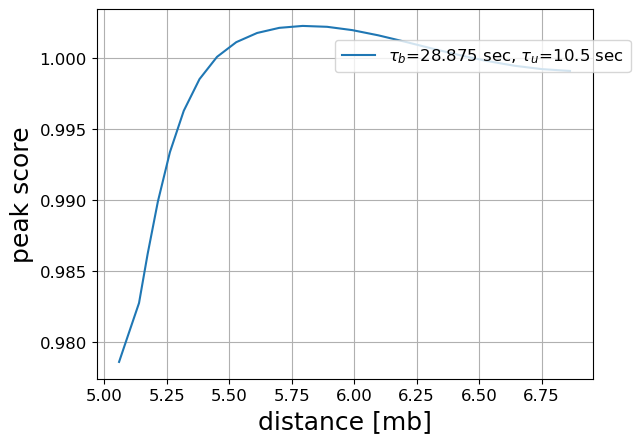

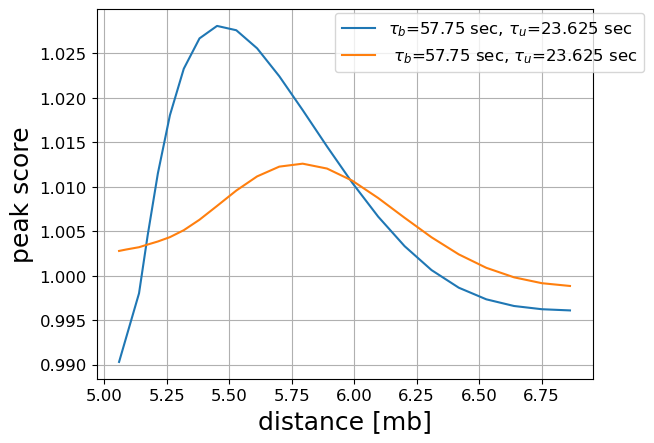

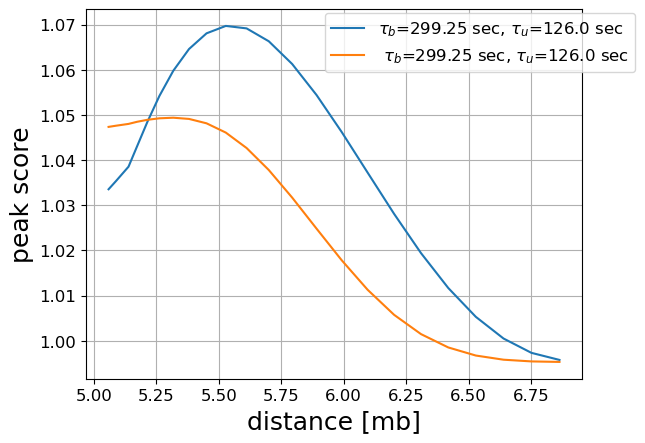

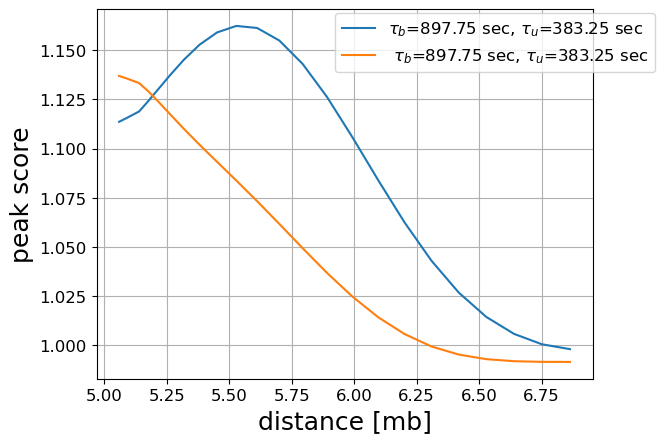

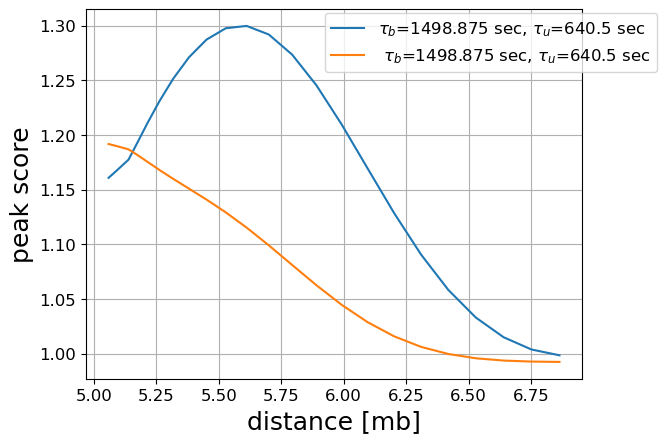

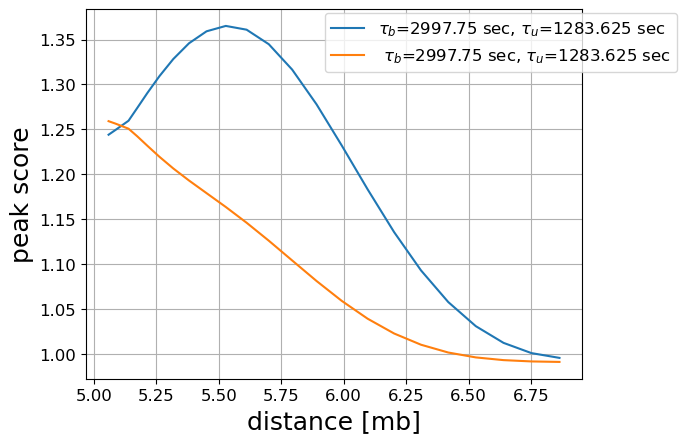

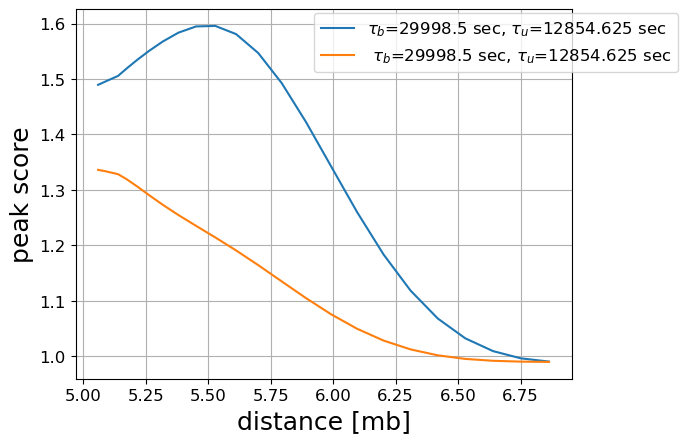

In [19]:
life_range, vel_range = 500, 1

clife_range = [ 11.43, 22.86,  114.29, 342.86, 571.43, 1142.86, 11428.57]
i = 1
def smooth(x, sigma = 3.95):
        return gaussian_filter1d(x, sigma)
convertor = 21.875*60/500
for clife_val in clife_range:
    i+=1
    for name in list(path_dict.keys()):
        params=[ast.literal_eval(i) for i in name.split('folder_')[1].split('_')[1::2]]
        face, back, clife, cof, life, slife, birth, pause, sep, site, mon, rep, step, vel = params
        if clife==clife_val:
            if life == 1500 and vel ==1 and np.round((clife/(clife+cof)),2)==0.7:
                f=pd.read_csv('../../../data/peakscore_with_orientation/peakscore_%s_hsteps_orientation_cool_res_10_points_eq.csv' % name)
                f = f[f['orientation']=='++']
                chr_dist = f['chr_distance']
                peak_score = f['peak_score']
                peaks = find_peaks(peak_score)
                #print(peaks)
                #plt.loglog(chr_dist, smooth(peak_score),label=r'$\tau$=%s, $\tau\prime$=%s, occup$\sim$0.9'%(clife,cof),color = colors[i])
                plt.plot(np.log10(chr_dist[1:]*1000), smooth(peak_score[1:], 3.5),label=r'$\tau_b$=%s sec, $\tau_u$=%s sec'%(int(clife)*convertor,int(cof)*convertor))
                #plt.title('lifetime = %s, velocity = %s'%(life,vel))
            if life == 500 and vel ==1 and np.round((clife/(clife+cof)),2)==0.7:
                f=pd.read_csv('../../../data/peakscore_with_orientation/peakscore_%s_hsteps_orientation_cool_res_10_points_eq.csv' % name)
                f = f[f['orientation']=='++']
                chr_dist = f['chr_distance']
                peak_score = f['peak_score']
                peaks = find_peaks(peak_score)
                #print(peaks)
                #plt.loglog(chr_dist, smooth(peak_score),label=r'$\tau$=%s, $\tau\prime$=%s, occup$\sim$0.9'%(clife,cof),color = colors[i])
                plt.plot(np.log10(chr_dist[1:]*1000), smooth(peak_score[1:], 3.5),label=r' $\tau_b$=%s sec, $\tau_u$=%s sec'%( int(clife)*convertor,int(cof)*convertor))
                #plt.title('lifetime = %s, velocity = %s'%(life,vel))
    #plt.xlim(4.3, 6.71)
    plt.grid(True)
    plt.ylabel('peak score',fontsize = 18)
    plt.xlabel('distance [mb]', fontsize = 18)
    plt.legend(loc=(0.481,0.83), fontsize = 11.95)
    plt.xticks(fontsize=11.95)
    plt.yticks(fontsize=11.95)
    #plt.title('convergent')
    #plt.legend()
    plt.savefig('../../../images/peak_and_distance_clife_%s_tandomp.pdf'%clife_val,bbox_inches = 'tight',transparent=True)
    plt.show()

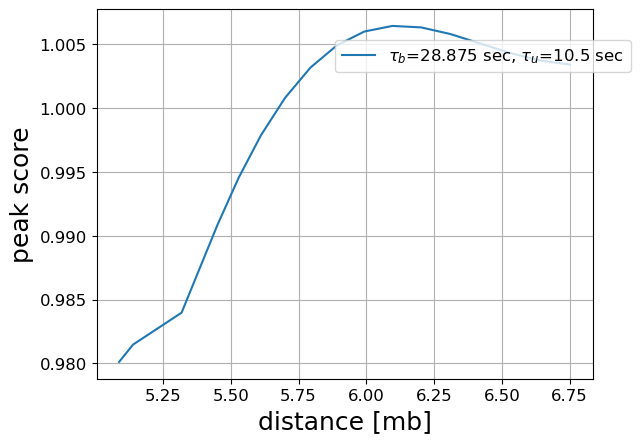

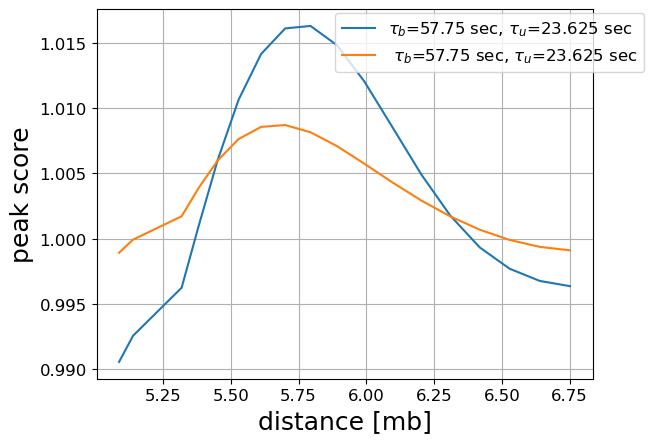

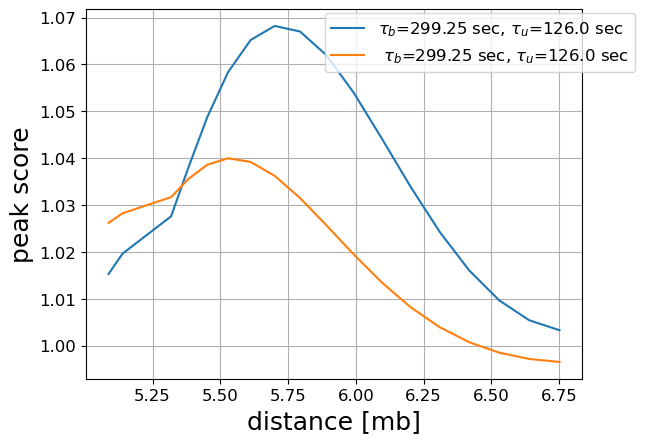

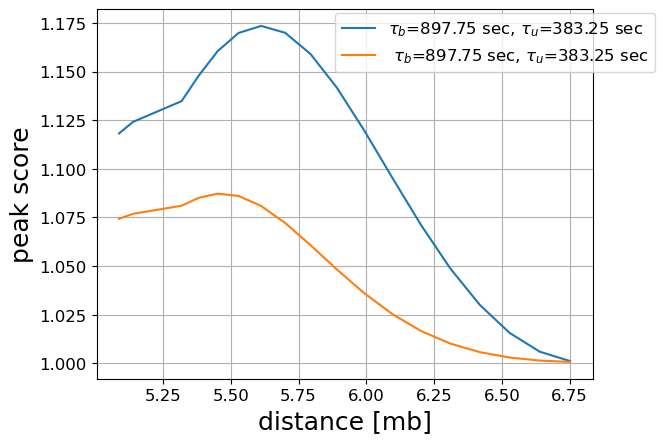

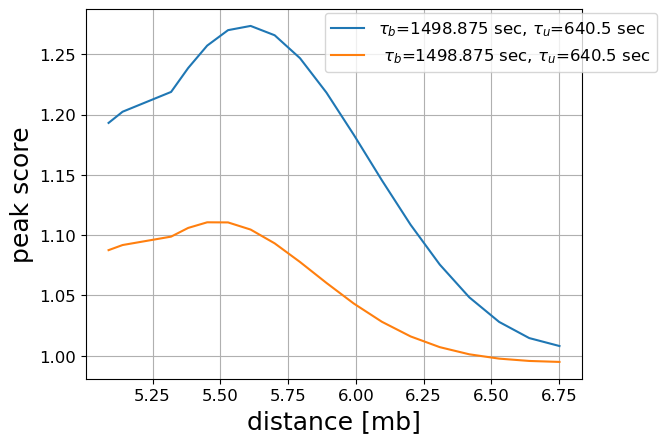

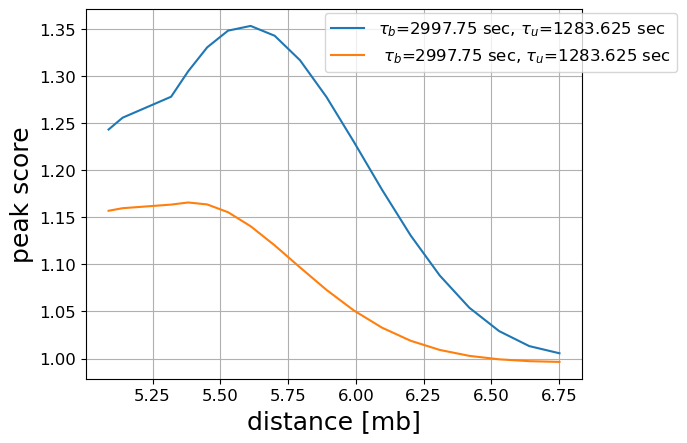

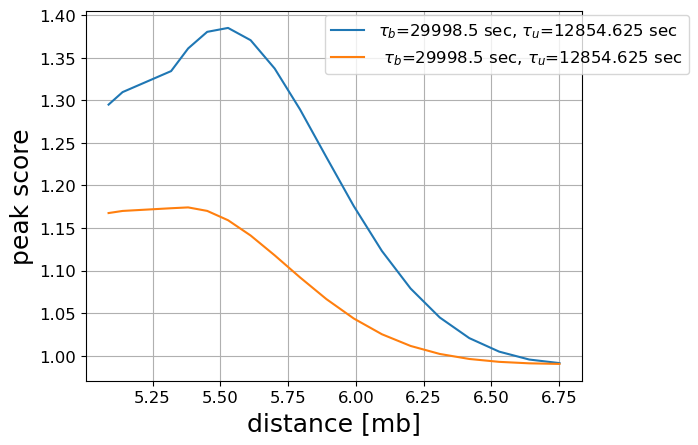

In [20]:
life_range, vel_range = 500, 1

clife_range = [ 11.43, 22.86,  114.29, 342.86, 571.43, 1142.86, 11428.57]
i = 1
def smooth(x, sigma = 3.95):
        return gaussian_filter1d(x, sigma)
convertor = 21.875*60/500
for clife_val in clife_range:
    i+=1
    for name in list(path_dict.keys()):
        #print(name)
        params=[ast.literal_eval(i) for i in name.split('folder_')[1].split('_')[1::2]]
        face, back, clife, cof, life, slife, birth, pause, sep, site, mon, rep, step, vel = params
        if clife==clife_val:
            if life == 1500 and vel ==1 and np.round((clife/(clife+cof)),2)==0.7:
                f=pd.read_csv('../../../data/peakscore_with_orientation/peakscore_%s_hsteps_orientation_cool_res_10_points_eq.csv' % name)
                f = f[f['orientation']=='--']
                chr_dist = f['chr_distance']
                peak_score = f['peak_score']
                peaks = find_peaks(peak_score)
                #print(peaks)
                #plt.loglog(chr_dist, smooth(peak_score),label=r'$\tau$=%s, $\tau\prime$=%s, occup$\sim$0.9'%(clife,cof),color = colors[i])
                plt.plot(np.log10(chr_dist[1:]*1000), smooth(peak_score[1:], 3.5),label=r'$\tau_b$=%s sec, $\tau_u$=%s sec'%(int(clife)*convertor,int(cof)*convertor))
                #plt.title('lifetime = %s, velocity = %s'%(life,vel))
            if life == 500 and vel ==1 and np.round((clife/(clife+cof)),2)==0.7:
                f=pd.read_csv('../../../data/peakscore_with_orientation/peakscore_%s_hsteps_orientation_cool_res_10_points_eq.csv' % name)
                f = f[f['orientation']=='--']
                chr_dist = f['chr_distance']
                peak_score = f['peak_score']
                peaks = find_peaks(peak_score)
                #print(peaks)
                #plt.loglog(chr_dist, smooth(peak_score),label=r'$\tau$=%s, $\tau\prime$=%s, occup$\sim$0.9'%(clife,cof),color = colors[i])
                plt.plot(np.log10(chr_dist[1:]*1000), smooth(peak_score[1:], 3.5),label=r' $\tau_b$=%s sec, $\tau_u$=%s sec'%( int(clife)*convertor,int(cof)*convertor))
                #plt.title('lifetime = %s, velocity = %s'%(life,vel))
    #plt.xlim(4.3, 6.71)
    plt.grid(True)
    plt.ylabel('peak score',fontsize = 18)
    plt.xlabel('distance [mb]', fontsize = 18)
    plt.legend(loc=(0.481,0.83), fontsize = 11.95)
    plt.xticks(fontsize=11.95)
    plt.yticks(fontsize=11.95)
    #plt.title('convergent')
    #plt.legend()
    plt.savefig('../../../images/peak_and_distance_clife_%s_tandomn.pdf'%clife_val,bbox_inches = 'tight',transparent=True)
    plt.show()

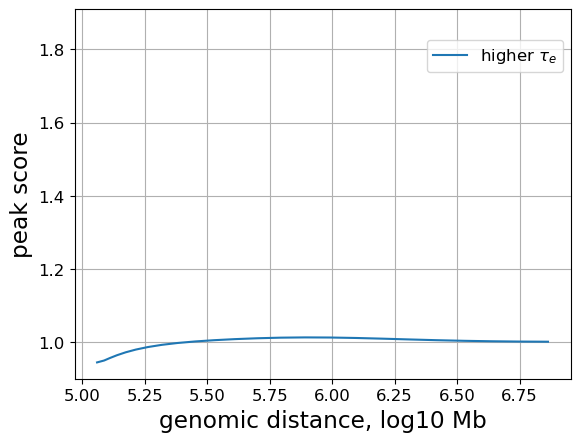

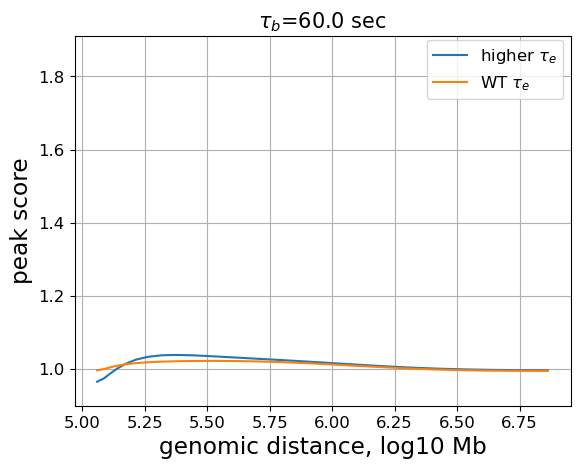

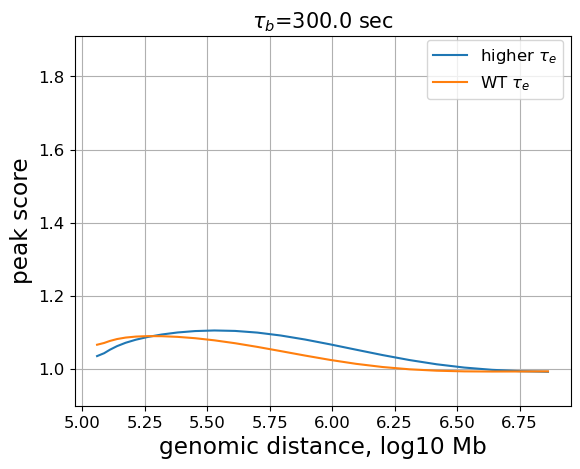

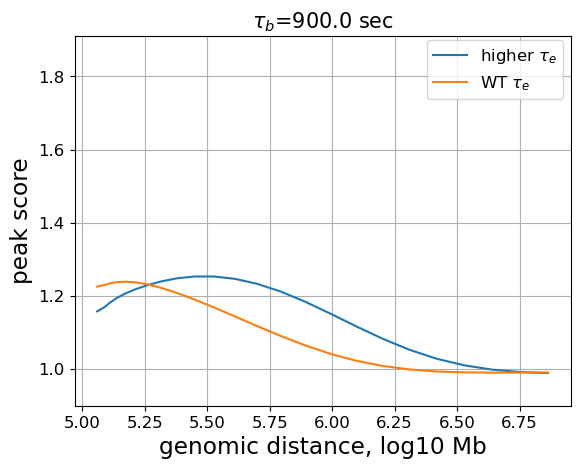

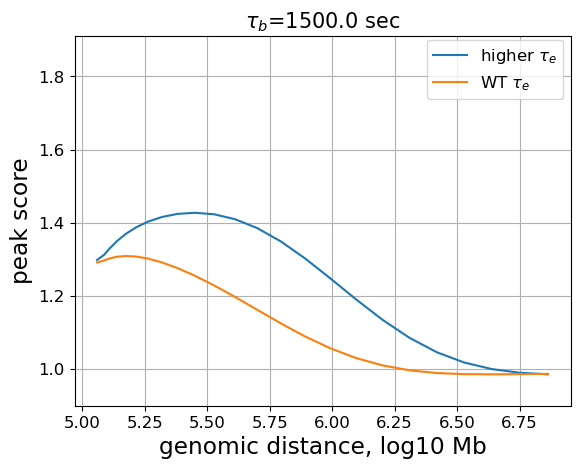

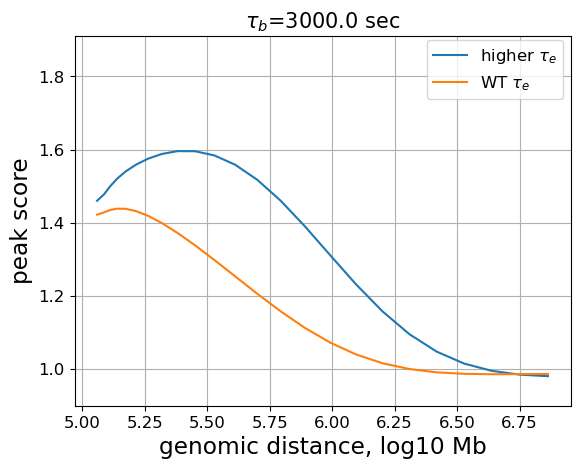

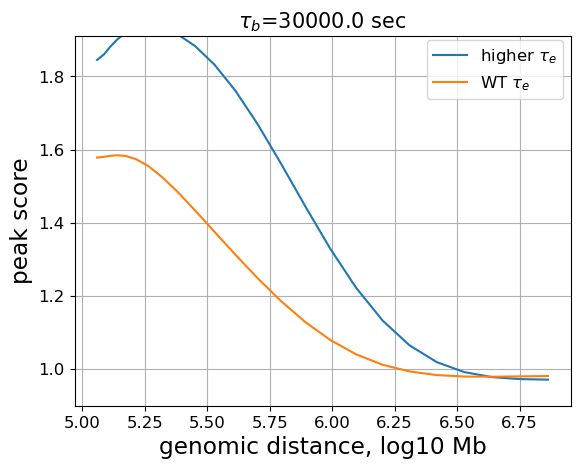

In [21]:
life_range, vel_range = 500, 1

clife_range = [ 11.43, 22.86,  114.29, 342.86, 571.43, 1142.86, 11428.57]
i = 1
convertor=21.875*60/500
for clife_val in clife_range:
    i+=1
    for name in list(path_dict.keys()):
        params=[ast.literal_eval(i) for i in name.split('folder_')[1].split('_')[1::2]]
        face, back, clife, cof, life, slife, birth, pause, sep, site, mon, rep, step, vel = params
        if step==400.0: continue
        if clife==clife_val:
            if life == 1500 and vel ==1 and np.round((clife/(clife+cof)),2)==0.7:
                f=pd.read_csv('../../../data/peakscore/peakscore_%s_hsteps_cool_res10_points.csv' % name)
                f = f.dropna()
                f=f[f['chr_distance']<=750000]
                #print(f)
                chr_dist = f['chr_distance']
                peak_score = f['peak_score']
                peaks = find_peaks(peak_score)
                #print(peaks)
                #plt.loglog(chr_dist, smooth(peak_score),label=r'$\tau$=%s, $\tau\prime$=%s, occup$\sim$0.9'%(clife,cof),color = colors[i])
                pixel_start = 1
                end_region=30
                plt.plot(np.log10(chr_dist[pixel_start:end_region]*1000), smooth(peak_score,3)[pixel_start:end_region],label = r'higher $\tau_e$')#,label=r'$\tau_b$=%s sec, $\tau_u$=%s sec'%(np.round(clife*convertor),np.round(cof*convertor)))
                #plt.title('lifetime = %s, velocity = %s'%(life,vel))
            if life == 500 and vel ==1 and np.round((clife/(clife+cof)),2)==0.7:
                f=pd.read_csv('../../../data/peakscore/peakscore_%s_hsteps_cool_res10_points.csv' % name)
                f=f.dropna()
                chr_dist = f['chr_distance']
                peak_score = f['peak_score']
                peaks = find_peaks(peak_score)
                #print(peaks)
                #plt.loglog(chr_dist, smooth(peak_score),label=r'$\tau$=%s, $\tau\prime$=%s, occup$\sim$0.9'%(clife,cof),color = colors[i])
                plt.plot(np.log10(chr_dist[pixel_start:end_region]*1000), smooth(peak_score,3)[pixel_start:end_region], label = r'WT $\tau_e$')#,label=r' $\tau_b$=%s sec, $\tau_u$=%s sec'%(np.round(clife*convertor),np.round(cof*convertor)))
                plt.title(r'$\tau_b$=%s sec'%(np.round(clife*convertor)), fontsize = 15)
    
    plt.grid(True)
    plt.ylabel('peak score',fontsize = 16.75)
    plt.xlabel('genomic distance, log10 Mb', fontsize = 16.75)
    plt.legend(loc=(0.71,0.83), fontsize = 11.95)
    plt.xticks(fontsize=11.95)
    plt.yticks(fontsize=11.95)
    #plt.legend()
    plt.ylim(0.9, 1.91)
    plt.savefig('../figs/peak_and_distance_clife_mag_%s.pdf'%clife_val,bbox_inches = 'tight',transparent=True)
    plt.show()

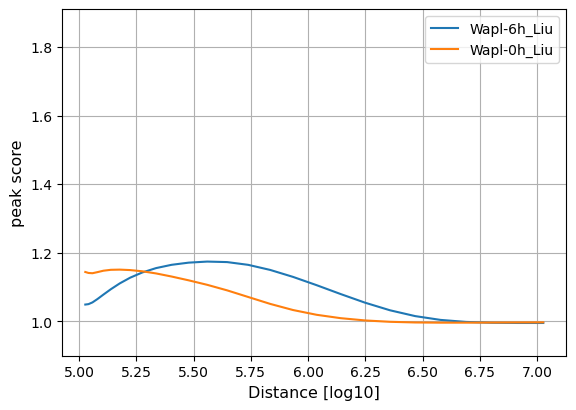

In [31]:
fig, axs = plt.subplots(1, 1, figsize=(6.5, 4.5))  # 3 rows, 1 column

new_sample_dict =['Wapl-6h_Liu','Wapl-0h_Liu',]

for name in new_sample_dict[:15]:
    data=pd.read_csv('/home1/rahmanin/start/polychrom/experimental_analysis/dots_from_other_papers/data/dots_vs_distance_peaks_motifs_%s.csv'%name)
    dist_conv=data[data['orientation']=='+-']['dist']
    score_conv=data[data['orientation']=='+-']['peak_score']
    dist_dive=data[data['orientation']=='-+']['dist']
    score_dive=data[data['orientation']=='-+']['peak_score']
    dist_tandemp=data[data['orientation']=='++']['dist']
    score_tandemp=data[data['orientation']=='++']['peak_score']
    dist_tandemn=data[data['orientation']=='--']['dist']
    score_tandemn=data[data['orientation']=='--']['peak_score']
    score_ave=data.groupby('dist')['peak_score'].mean()
    #print(score_ave.iloc[:])
    axs.plot(np.log10(dist_conv),smooth(score_ave, 1.5),label='%s'%name)
#axs.set_ylim(0.9, 1.195)
#plt.ylabel('Peak score',fontsize = 11.5)
plt.xlabel('off-diagonal distance [mb]',fontsize = 11.5)
#axs.set_title('all orientations', fontsize = 11.5)
axs.grid(True)
axs.set_xlabel('Distance [log10]', fontsize = 11.5)
#ax.set_ylim(0.95,1.35)
#axs.legend( bbox_to_anchor=(1.5, 0.8),loc='right')
axs.legend()
axs.set_ylabel('peak score',fontsize = 11.5)
plt.ylim(0.9, 1.91)
#plt.suptitle('Observed, ctcf & motifs, Rini\'s new data', fontsize=15, y=1.05)
#plt.tight_layout(rect=[10, 10.3, 10.15, 10.95])
plt.savefig('../../../images/newobserved_for_ctcf&motifs_from_papers_d.pdf', bbox_inches = 'tight')
plt.show()

### binding time vs occupancy

In [8]:
file = pd.read_csv('../../../data/peak_score_averaged_hsteps_coolres10_points_eq.csv')
file

,life,velocity,clife,cof,peak_ave
0,1500.0,1,11.43,1.27,1.007326
1,2500.0,1,11.43,1.27,1.001581
2,3500.0,1,11.43,1.27,1.001905
3,4500.0,1,11.43,1.27,1.016580
4,500.0,1,11.43,1.27,1.016938
...,...,...,...,...,...
494,2500.0,1,571.43,97.96,1.316428
495,3500.0,1,571.43,97.96,1.331068
496,4500.0,1,571.43,97.96,1.319360
497,500.0,1,571.43,97.96,1.207244


In [9]:
lifetime = file['life']
velocity = file['velocity']
clife = file['clife']
cof = file['cof']
file['occupancy']=(file['clife']/(file['clife']+file['cof'])).round(2)
unique_life = np.unique(lifetime)
unique_vel = np.unique(velocity)
unique_clife = np.unique(clife)
unique_cof = np.unique(cof)
unique_occupancy = np.unique(file['occupancy'])
file

,life,velocity,clife,cof,peak_ave,occupancy
0,1500.0,1,11.43,1.27,1.007326,0.90
1,2500.0,1,11.43,1.27,1.001581,0.90
2,3500.0,1,11.43,1.27,1.001905,0.90
3,4500.0,1,11.43,1.27,1.016580,0.90
4,500.0,1,11.43,1.27,1.016938,0.90
...,...,...,...,...,...,...
494,2500.0,1,571.43,97.96,1.316428,0.85
495,3500.0,1,571.43,97.96,1.331068,0.85
496,4500.0,1,571.43,97.96,1.319360,0.85
497,500.0,1,571.43,97.96,1.207244,0.85


In [10]:
convertor = 21.875*60/500
file['clife']=file['clife']
file['cof']=file['cof']
lifetime = file['life']
velocity = file['velocity']
clife = file['clife']
cof = file['cof']
occupancy = file['occupancy']


unique_life = np.unique(lifetime)
unique_vel = np.unique(velocity)
unique_clife = np.unique(clife)
unique_cof = np.unique(cof)
unique_occup = np.unique(occupancy)
file

,life,velocity,clife,cof,peak_ave,occupancy
0,1500.0,1,11.43,1.27,1.007326,0.90
1,2500.0,1,11.43,1.27,1.001581,0.90
2,3500.0,1,11.43,1.27,1.001905,0.90
3,4500.0,1,11.43,1.27,1.016580,0.90
4,500.0,1,11.43,1.27,1.016938,0.90
...,...,...,...,...,...,...
494,2500.0,1,571.43,97.96,1.316428,0.85
495,3500.0,1,571.43,97.96,1.331068,0.85
496,4500.0,1,571.43,97.96,1.319360,0.85
497,500.0,1,571.43,97.96,1.207244,0.85


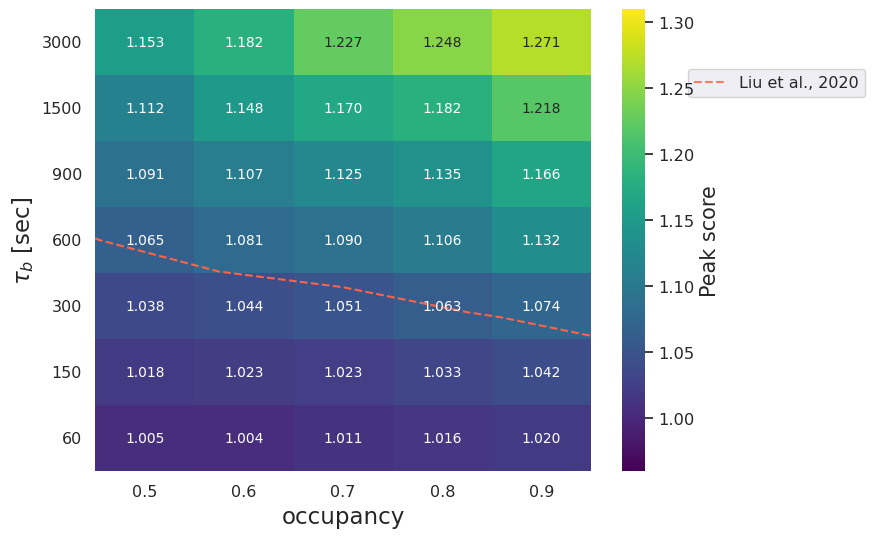

In [12]:
list_life, list_vel = [500], [1]

numline_c = 7
numline_o = 5
occupancy_range = [0.5, 0.6, 0.7, 0.8, 0.9]
file = file[file['occupancy'].isin(occupancy_range)]
lifetime = file['life']
velocity = file['velocity']

for life in list(list_life):
    for vel in list(list_vel):
        new_file_filtered_unique = file[(lifetime == life) & (velocity == vel)][['clife', 'occupancy', 'peak_ave']]
        
        # Group by 'clife' and 'occupancy_bin', and calculate the mean of 'isoscore'
        dtaframe_grouped = new_file_filtered_unique.groupby(['clife', 'occupancy'], as_index=False).mean()
        convertor = 21.875 * 60 / 500
        dtaframe_grouped['clife'] = (dtaframe_grouped['clife'] * convertor).round()
        dtaframe_grouped = dtaframe_grouped.drop_duplicates(keep='first')
        dtaframe_grouped = dtaframe_grouped[dtaframe_grouped['clife'] > 30]
        dtaframe_grouped = dtaframe_grouped[dtaframe_grouped['clife'] <= 3000]
        heatmap_data = dtaframe_grouped.pivot('clife', 'occupancy', 'peak_ave')
        
        plt.figure(figsize=(8, 6))
        im = sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt=".3f", vmin=0.96, vmax=1.31, cbar_kws={'label': 'Frip score'})
        sns.set(font_scale=0.831)
        cbar = im.collections[0].colorbar
        cbar.ax.tick_params(labelsize=11.75)
        cbar.set_label('Peak score', fontsize=15)
        
        # Add equipotential lines for loop size = 700
        smooth_scale = 1
        z = ndimage.zoom(heatmap_data.to_numpy(), smooth_scale)
        cntr1 = im.contour(np.linspace(0, numline_o, numline_o * smooth_scale),
                           np.linspace(0, numline_c, numline_c * smooth_scale),
                           heatmap_data.to_numpy(), levels=[1.066], colors='tomato', linestyles='dashed', alpha=1)
        
        hansen_line, = plt.plot([], [], color='tomato', linestyle='dashed', alpha=0.83, label='Liu et al., 2020')

        # Format tick labels
        im.set_xticklabels([int(float(t.get_text())) if float(t.get_text()).is_integer() else t.get_text() for t in im.get_xticklabels()])
        im.set_yticklabels([int(float(t.get_text())) if float(t.get_text()).is_integer() else t.get_text() for t in im.get_yticklabels()])

        plt.xlabel('occupancy', fontsize=16.5)
        plt.xticks(fontsize=11.5, rotation=0)
        plt.ylabel(r'$\tau_b$ [sec]', fontsize=16.5)
        plt.yticks(fontsize=11.5, rotation=0)
        #plt.title(r'$\tau_E$ = %s sec, velocity = %s' % (np.round(life * convertor), vel), fontsize=11.95)
        # Add legend
        plt.legend(handles=[hansen_line], loc=(1.195, 0.81), fontsize=11.5)
        plt.gca().invert_yaxis()
        plt.savefig('peaksweep_for_occupancy_%s_%s.pdf'%(life, vel), transparent = True, bbox_inches = 'tight')
        plt.show()


### grouping for frip

In [30]:
frip = pd.read_csv('../../../data/fripscore_sep_100.csv')
#print(frip)

frip = frip[frip[' clife']>=1.5]
frip [' occupancy']=(frip[' clife']/(frip[' clife']+frip[' cof'])).round(2)
frip = frip[(frip[' clife']<=500000)&(frip[' cof']>0.15)]

lifetime = frip['lifetime']
velocity = frip[' velocity']
clife = frip[' clife']
cof = frip[' cof']
#frip['occup']=(1*(frip[' clife'])/(frip[' clife']+frip[' cof']))

unique_life = np.unique(lifetime)
unique_vel = np.unique(velocity)
unique_clife = np.unique(clife)
unique_cof = np.unique(cof)
unique_occupancy = np.unique(frip[' occupancy'])

#frip=frip[frip[' clife']==10*frip[' cof']]

frip

,lifetime,velocity,clife,cof,sep,fripscore,occupancy
23,500.0,1,1.5,1.0,100,0.012940,0.60
24,500.0,1,1.5,1.5,100,0.012349,0.50
25,500.0,1,1.5,100000.0,100,0.009723,0.00
26,500.0,1,1.5,15.0,100,0.009696,0.09
27,500.0,1,1.5,150.0,100,0.009957,0.01
...,...,...,...,...,...,...,...
1099,500.0,3,7.5,15.0,100,0.021341,0.33
1100,500.0,3,7.5,150.0,100,0.015836,0.05
1101,500.0,3,7.5,3.0,100,0.040676,0.71
1102,500.0,3,7.5,30.0,100,0.014962,0.20


In [31]:
bins = [0.03, 0.3,  0.55,   0.8, 0.95, 1.0]

labels = [0.15,  0.45,  0.67, 0.9, 0.97]

In [32]:
new_file_filtered_unique = frip[['lifetime',' velocity',' clife',' occupancy',' fripscore']]

new_file_filtered_unique[' occupancy_bin'] = pd.cut(new_file_filtered_unique[' occupancy'], bins=bins, labels=labels, right=False)

dtaframe = new_file_filtered_unique[['lifetime',' velocity',' clife', ' occupancy_bin', ' fripscore']]
dtafram = dtaframe.dropna()
dtaframe = new_file_filtered_unique[['lifetime',' velocity',' clife', ' occupancy_bin', ' fripscore']]
dtaframe_grouped = dtaframe.groupby(['lifetime',' velocity',' clife', ' occupancy_bin'], as_index=False).mean()
dtaframe_grouped_frip = dtaframe.dropna()
dtaframe_grouped_frip

/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,lifetime,velocity,clife,occupancy_bin,fripscore
23,500.0,1,1.5,0.67,0.012940
24,500.0,1,1.5,0.45,0.012349
26,500.0,1,1.5,0.15,0.009696
31,500.0,1,1.5,0.45,0.011134
32,500.0,1,1.5,0.15,0.010380
...,...,...,...,...,...
1099,500.0,3,7.5,0.45,0.021341
1100,500.0,3,7.5,0.15,0.015836
1101,500.0,3,7.5,0.67,0.040676
1102,500.0,3,7.5,0.15,0.014962


In [33]:
file = pd.read_csv('../../../data/peak_score_averaged_hsteps_coolres10_points_eq.csv')
file
file = file[file['cof']>=0.3]
file = file[file['clife']>=1.5]
file ['occupancy']=(file['clife']/(file['clife']+file['cof'])).round(2)
lifetime = file['life']
velocity = file['velocity']
clife = file['clife']
cof = file['cof']
#frip['occup']=(1*(frip[' clife'])/(frip[' clife']+frip[' cof']))

unique_life = np.unique(lifetime)
unique_vel = np.unique(velocity)
unique_clife = np.unique(clife)
unique_cof = np.unique(cof)
unique_occupancy = np.unique(file['occupancy'])

#frip=frip[frip[' clife']==10*frip[' cof']]

vel, life = 1, 500
file_100 = file
new_file_filtered_unique = file_100[['life','velocity','clife','occupancy','peak_ave']]

new_file_filtered_unique['occupancy_bin'] = pd.cut(new_file_filtered_unique['occupancy'], bins=bins, labels=labels, right=False)

dtaframe = new_file_filtered_unique[['life','velocity','clife', 'occupancy_bin', 'peak_ave']]
dtafram = dtaframe.dropna()
dtaframe = new_file_filtered_unique[['life','velocity','clife', 'occupancy_bin', 'peak_ave']]
dtaframe_grouped_peak = dtaframe.groupby(['life','velocity','clife', 'occupancy_bin'], as_index=False).mean()
dtaframe_grouped_peak = dtaframe_grouped_peak.dropna()
dtaframe_grouped_peak

,life,velocity,clife,occupancy_bin,peak_ave
0,500.0,1,11.43,0.15,0.993649
1,500.0,1,11.43,0.45,0.999429
2,500.0,1,11.43,0.67,0.999715
3,500.0,1,11.43,0.90,1.010837
6,500.0,1,22.86,0.45,1.005235
...,...,...,...,...,...
323,5500.0,1,3428.57,0.90,1.778406
326,5500.0,1,11428.57,0.45,1.652985
327,5500.0,1,11428.57,0.67,1.782760
328,5500.0,1,11428.57,0.90,1.881820


In [34]:
occup_range = np.unique(dtaframe_grouped_peak['occupancy_bin'])
occup_range

array([0.15, 0.45, 0.67, 0.9 , 0.97])

In [162]:
lifes, vels = [500, 1500] , [1, 3]

file= open('../../data/peak_frip_tau_cool_res10_grouped.csv','w')
file.write('vel,life,clife,occupancy_bin,frip_ave,peak_aver\n')
mat = []
frip = dtaframe_grouped_frip
peak =dtaframe_grouped_peak
for life in lifes:
    for vel in vels:
        if (life==1500 and vel==3): continue
        for clife in unique_clife:
            for occup_val in occup_range:
                #print(clife)
                new_frip = frip[(frip['lifetime'] == life)&(frip[' velocity'] == vel)&(frip[' clife']==clife)&(frip[' occupancy_bin']==occup_val)][[ ' fripscore']]
                new_peak = peak[(peak['life'] == life)&(peak['velocity'] == vel)&(peak['clife']==clife)&(peak['occupancy_bin']==occup_val)][[ 'peak_ave']]
                new_frip_filtered = new_frip.drop_duplicates(keep = 'first')
                new_peak_filtered = new_peak.drop_duplicates(keep = 'first')
                #new_frip_filtered = new_frip_filtered.sort_values(' occupancy_bin')
                #new_peak_filtered = new_peak_filtered.sort_values('occupancy_bin')
                #new_clife = new_peak_filtered['occupancy_bin']
                frip_score = new_frip_filtered[' fripscore']
                peak_score = new_peak_filtered['peak_ave']
                if frip_score.empty or peak_score.empty:
                    #print('y')
                    continue
                mat.append([vel, life, clife, np.mean(frip_score), np.mean(peak_score)])
                file.write('%s,%s,%s,%s,%s,%s\n'%(vel, life, clife, occup_val,np.mean(frip_score), np.mean(peak_score)))

mat = np.array(mat)
file.close()

In [163]:
file = pd.read_csv('../../data/peak_frip_tau_cool_res10_grouped.csv')
file


,vel,life,clife,occupancy_bin,frip_ave,peak_aver
0,1,500,1.5,0.15,0.009592,0.993063
1,1,500,1.5,0.45,0.011742,0.996881
2,1,500,1.5,0.67,0.012940,0.996376
3,1,500,3.0,0.15,0.010193,0.992834
4,1,500,3.0,0.45,0.013022,0.994830
...,...,...,...,...,...,...
103,1,1500,5000.0,0.67,0.518537,1.541368
104,1,1500,5000.0,0.90,0.595922,1.607363
105,1,1500,5000.0,0.97,0.607146,1.636485
106,1,1500,15000.0,0.90,0.624633,1.638503


/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "ppt" which is no longer supported as of 3.3 and will become an error in 3.6


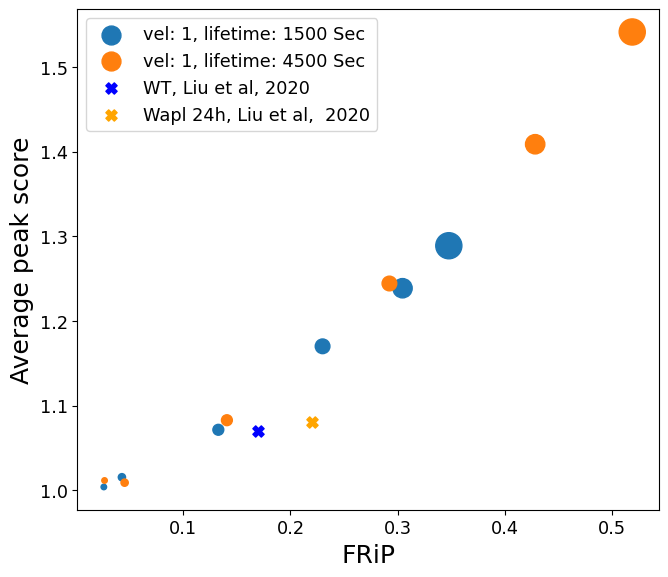

In [174]:

sns.reset_defaults()
data = pd.read_csv('../../data/peak_frip_tau_cool_res10_grouped.csv')
data = data[data['occupancy_bin']==0.67]
data=data[(data['clife']>3)&(data['clife']<=5000)]
unique_vel = data['vel'].unique()
unique_life = data['life'].unique()
#print(data)
#colors = plt.cm.viridis(np.linspace(0, 1, len(unique_vel) * len(unique_life)))

plt.figure(figsize=(7.5, 6.5))
for i, vel in enumerate(unique_vel):
    for j, life in enumerate(unique_life):
        if vel==3.0: continue
        subset = data[(data['vel'] == vel) & (data['life'] == life)]
        plt.scatter(subset['frip_ave'],subset['peak_aver'],  
                    s=np.sqrt(subset['clife'])*5, label=f'vel: {vel}, lifetime: {life*3} Sec')
Liu_WT = [0.17, 1.07]
Liu_Wapl = [0.22, 1.08]
plt.scatter(np.array(Liu_WT)[0], np.array(Liu_WT)[1], label='WT, Liu et al, 2020',color='blue', marker='X',s=65)
plt.scatter(np.array(Liu_Wapl)[0], np.array(Liu_Wapl)[1],label='Wapl 24h, Liu et al,  2020',color='orange', marker = 'X',s=65)
plt.xlabel('FRiP',fontsize=18)
plt.ylabel('Average peak score', fontsize =18)
#plt.title('Frip vs peak')
#plt.legend(  bbox_to_anchor=(1,1))
#plt.ylim(0.9,1.35)
plt.xticks(fontsize=12.75)
plt.yticks(fontsize=12.75)
plt.legend(fontsize=12.75)
plt.savefig('../../images/peak_vs_frip_occup_67.pdf',transparent=True, ppt=500)

#plt.grid(True)
plt.show()

### peak score wt vs wapl

In [13]:
file = pd.read_csv('../../../data/peak_score_averaged_hsteps_coolres10_points_eq.csv')
file

,life,velocity,clife,cof,peak_ave
0,1500.0,1,11.43,1.27,1.007326
1,2500.0,1,11.43,1.27,1.001581
2,3500.0,1,11.43,1.27,1.001905
3,4500.0,1,11.43,1.27,1.016580
4,500.0,1,11.43,1.27,1.016938
...,...,...,...,...,...
494,2500.0,1,571.43,97.96,1.316428
495,3500.0,1,571.43,97.96,1.331068
496,4500.0,1,571.43,97.96,1.319360
497,500.0,1,571.43,97.96,1.207244


In [14]:
file['occupancy']=(file['clife']/(file['clife']+file['cof'])).round(2)

In [15]:
peak_wt, peak_wapl  = file[file['life']==500], file[file['life']==1500]
peak_wt

,life,velocity,clife,cof,peak_ave,occupancy
4,500.0,1,11.43,1.27,1.016938,0.90
10,500.0,1,11.43,11.43,0.999429,0.50
16,500.0,1,11.43,2.86,1.004737,0.80
27,500.0,1,11.43,7.62,0.999715,0.60
33,500.0,1,11.43,97.96,0.993649,0.10
...,...,...,...,...,...,...
473,500.0,1,571.43,4897.96,1.020888,0.10
479,500.0,1,571.43,571.43,1.112119,0.50
485,500.0,1,571.43,63.49,1.217627,0.90
491,500.0,1,571.43,857.14,1.091705,0.40


In [16]:
common_columns = [ 'velocity', 'clife', 'cof', 'occupancy']

# Merge the datasets on the common columns
peak_wt_70 = peak_wt[peak_wt['occupancy']==0.70]
peak_wapl_70 = peak_wapl[peak_wapl['occupancy']==0.70]
merged_df = pd.merge(peak_wt_70, peak_wapl_70, on=common_columns, how='inner')
#merged_df = merged_df[(merged_df['clife'])!=3428.57]
merged_df

,life_x,velocity,clife,cof,peak_ave_x,occupancy,life_y,peak_ave_y
0,500.0,1,114.29,48.98,1.050948,0.7,1500.0,1.062443
1,500.0,1,1142.86,489.80,1.226533,0.7,1500.0,1.376011
2,500.0,1,11428.57,4897.96,1.290693,0.7,1500.0,1.552249
3,500.0,1,22.86,9.80,1.011325,0.7,1500.0,1.013867
4,500.0,1,228.57,97.96,1.089572,0.7,1500.0,1.121909
5,500.0,1,2285.71,979.59,1.247207,0.7,1500.0,1.443920
6,500.0,1,342.86,146.94,1.125420,0.7,1500.0,1.158903
7,500.0,1,3428.57,1469.39,1.262382,0.7,1500.0,1.470253
8,500.0,1,57.14,24.49,1.023277,0.7,1500.0,1.026855
9,500.0,1,571.43,244.90,1.169822,0.7,1500.0,1.276771


/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "ppt" which is no longer supported as of 3.3 and will become an error in 3.6
  


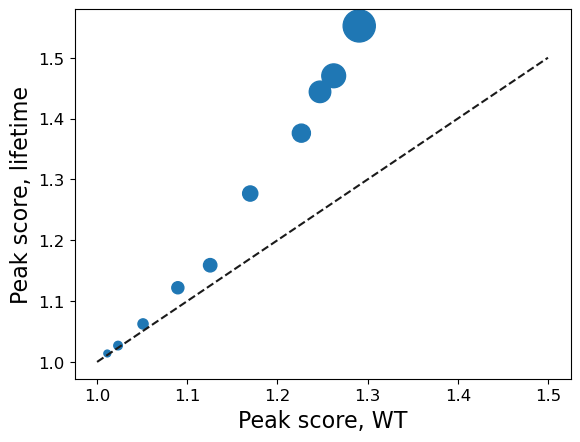

In [17]:
sns.reset_defaults()

plt.scatter( merged_df['peak_ave_x'], merged_df['peak_ave_y'], s=np.sqrt(merged_df['clife'])*5)

plt.plot([1,1.5],[1,1.5],'--k')
plt.xlabel('Peak score, WT',fontsize=16)
plt.ylabel('Peak score, lifetime', fontsize =16)
#plt.title('Frip vs peak')
#plt.legend(  bbox_to_anchor=(1,1))
#plt.ylim(0.9,1.35)
#plt.legend(fontsize=11.95)
plt.xticks(fontsize=11.95)
plt.yticks(fontsize=11.95)
plt.savefig('peakwt_vs_wapl.pdf',transparent=True, ppt=500)

#plt.grid(True)
plt.show()

In [18]:
clife_list = [22.86, 342.86, 571.43, 11428.57]

merged_df_sort = merged_df[merged_df['clife'].isin(clife_list)]
merged_df_sort = merged_df_sort.sort_values('clife')
merged_df_sort

,life_x,velocity,clife,cof,peak_ave_x,occupancy,life_y,peak_ave_y
3,500.0,1,22.86,9.80,1.011325,0.7,1500.0,1.013867
6,500.0,1,342.86,146.94,1.125420,0.7,1500.0,1.158903
9,500.0,1,571.43,244.90,1.169822,0.7,1500.0,1.276771
2,500.0,1,11428.57,4897.96,1.290693,0.7,1500.0,1.552249


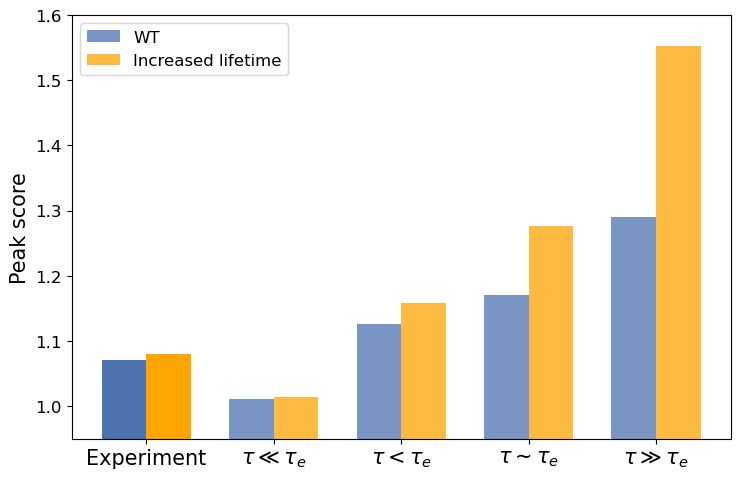

In [19]:
# Define tau_e for comparison
tau_e = 500
convertor = 21.875*60/500
# Add a new column for labels based on conditions
def get_label(clife, tau_e):
    if clife < 0.1 * tau_e:
        return r'$\tau \ll \tau_e$'
    elif 0.1 * tau_e < clife < tau_e:
        return r'$\tau < \tau_e$'
    elif clife > 1.5 * tau_e:
        return r'$\tau \gg \tau_e$'
    else:
        return r'$\tau \sim \tau_e$'

merged_df_sort['label'] = merged_df_sort['clife'].apply(lambda x: get_label(x, tau_e))

# Plotting
fig, ax = plt.subplots(figsize=(8.5, 5.5))

# Define the bar width
bar_width = 0.35

# Plot bars for experimental data at the beginning
exp_index = 0  # Positioning them at the beginning of the plot
exp_x = 1.07
exp_y = 1.08
bars3 = ax.bar(exp_index, exp_x, bar_width,  color='b')#WT, Liu et al, 2020 label =r'WT, Liu et al, 2021',
bars4 = ax.bar(exp_index + bar_width, exp_y, bar_width, color='orange')# label=r'Wapl 6h, Liu et al, 2021'

# Create positions for bars and plot for merged_df_sort
index = np.arange(1, len(merged_df_sort) + 1)  # Start from 1 for the subsequent data
bars1 = ax.bar(index, merged_df_sort['peak_ave_x'], bar_width, label= 'WT', color='b', alpha = 0.75) #alternative label r'$\tau_E$ =%s sec'%(500*convertor)
bars2 = ax.bar(index + bar_width, merged_df_sort['peak_ave_y'], bar_width, label= 'Increased lifetime', color='orange', alpha = 0.75) #alternative label r'$\tau_E = %s sec$'%(1500*convertor)

# Set labels and title
ax.set_ylabel('Peak score', fontsize=15)

# Adjust x-ticks to align with the bars
ax.set_xticks(np.append(exp_index + bar_width / 2, index + bar_width / 2))
ax.set_xticklabels(['Experiment'] + list(merged_df_sort['label']), fontsize = 15)
#ax.set_yticklabels(fontsize = 15)
# Set y-axis limits
ax.set_ylim(0.95, 1.6)
ax.tick_params(axis='y', labelsize=12) 
# Add a legend
ax.legend(fontsize = 11.95)
plt.savefig('bar_for_peak.pdf', transparent = True)
# Show plot
plt.show()
